#Импорт библиотек



In [23]:
import pandas as pd # Импорт необходимых библиотек
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Загрузка данных
train = pd.read_excel('train.xlsx')
test = pd.read_excel('test.xlsx')
train.tail()# загружаем данные и смотрим  первые  пять записей  и  делаем  первые  выводы о данных



dt  Цена на арматуру
395 2022-08-01             47500
396 2022-08-08             49000
397 2022-08-15             47500
398 2022-08-22             46500
399 2022-08-29             46000

In [24]:
# !pip uninstall -y numpy catboost
# !pip install numpy==1.23.5
!pip install catboost
import catboost
from catboost import CatBoostRegressor

#Первичный анализ


In [25]:
# Первичный анализ данных
print(train.shape)  # Размер тренировочного набора
print(test.shape)   # Размер тестового набора
print(train.describe())  # Статистика по данным

(400, 2)
(28, 2)
                        dt  Цена на арматуру
count                  400        400.000000
mean   2018-11-01 12:00:00      39229.475000
min    2015-01-05 00:00:00      21000.000000
25%    2016-12-03 06:00:00      31075.000000
50%    2018-11-01 12:00:00      35450.000000
75%    2020-09-29 18:00:00      42000.000000
max    2022-08-29 00:00:00      79000.000000
std                    NaN      13407.979668


<Axes: >

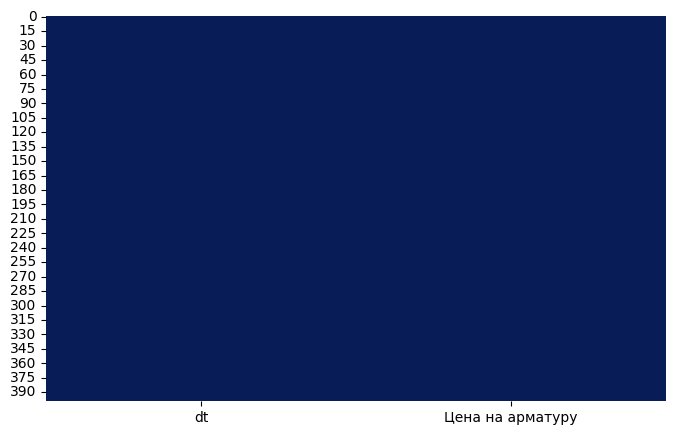

In [26]:
# Визуализация пропущенных данных
plt.figure(figsize = (8,5))
sns.heatmap(train.isnull(),cmap="YlGnBu_r",cbar=False)

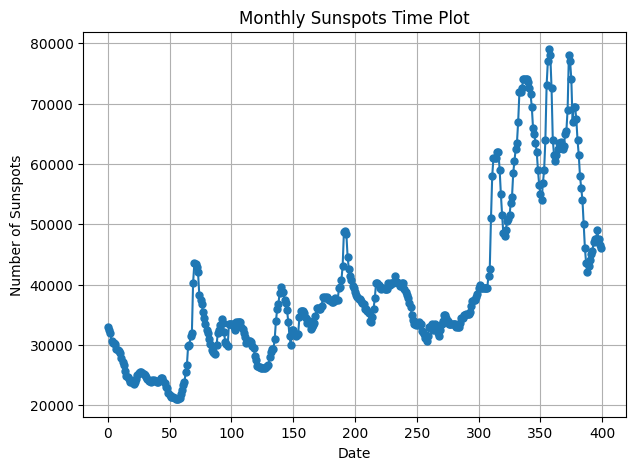

In [27]:
# Визуализация временного ряда цен на арматуру
plt.figure(figsize=(7, 5))
plt.plot(train.index, train['Цена на арматуру'], marker='o', linestyle='-', markersize=5)
plt.xlabel('Date')
plt.ylabel('Number of Sunspots')
plt.title('Monthly Sunspots Time Plot')
plt.grid(True)
plt.show()

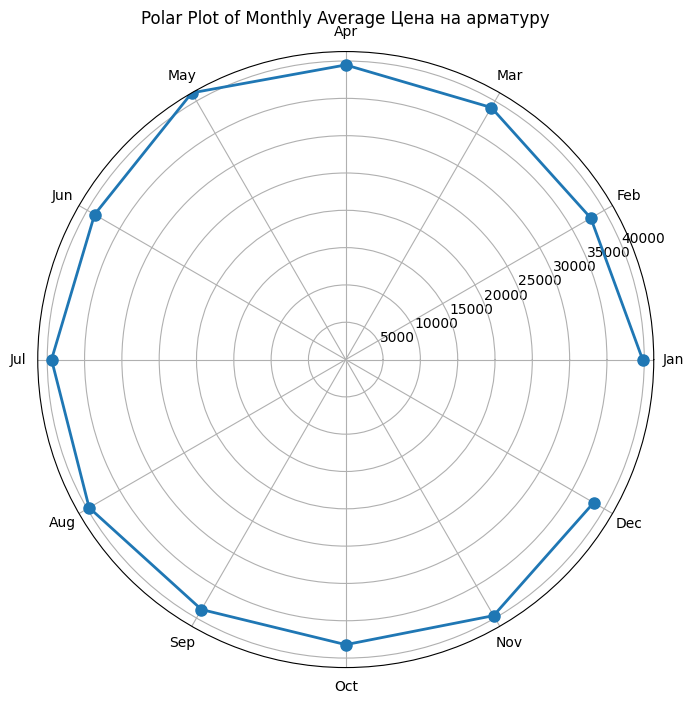

In [28]:

# Создаем копию данных
train1 = train.copy()

# Извлекаем год и месяц из даты
train1['year'] = pd.DatetimeIndex(train1['dt']).year
train1['month'] = pd.DatetimeIndex(train1['dt']).month

# Группируем по месяцу и вычисляем среднее значение
monthly_average = train1.groupby('month')['Цена на арматуру'].mean()

# Углы для каждого месяца (12 месяцев)
theta = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # 12 точек, чтобы избежать наложения
radii = monthly_average.values

# Названия месяцев
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Полярный график
plt.figure(figsize=(10, 8))
ax = plt.subplot(111, projection='polar')

# Рисуем график
ax.plot(theta, radii, marker='o', linestyle='-', linewidth=2, markersize=8)

# Добавляем названия месяцев
ax.set_xticks(theta)
ax.set_xticklabels(months)

# Устанавливаем пределы для оси y
ax.set_ylim(0, radii.max() + 10)

# Заголовок
plt.title('Polar Plot of Monthly Average Цена на арматуру', pad=20)

# Показать график
plt.show()

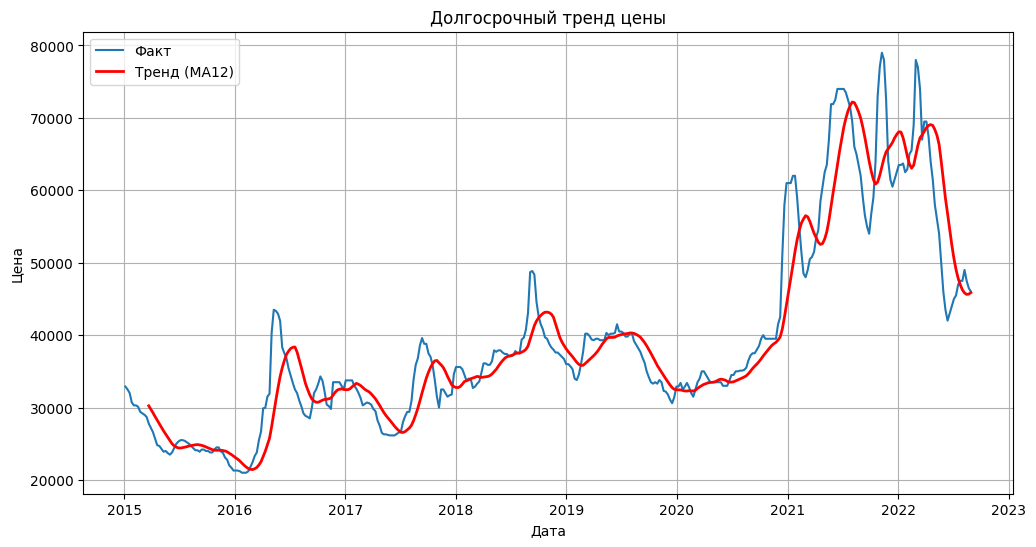

In [29]:
# Скользящее среднее за 12 месяцев (если данные месячные)
train['Price_MA12'] = train['Цена на арматуру'].rolling(window=12).mean()

# График тренда
plt.figure(figsize=(12, 6))
plt.plot(train['dt'],train['Цена на арматуру'], label='Факт')
plt.plot(train['dt'], train['Price_MA12'], label='Тренд (MA12)', color='red', linewidth=2)
plt.title('Долгосрочный тренд цены')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid()

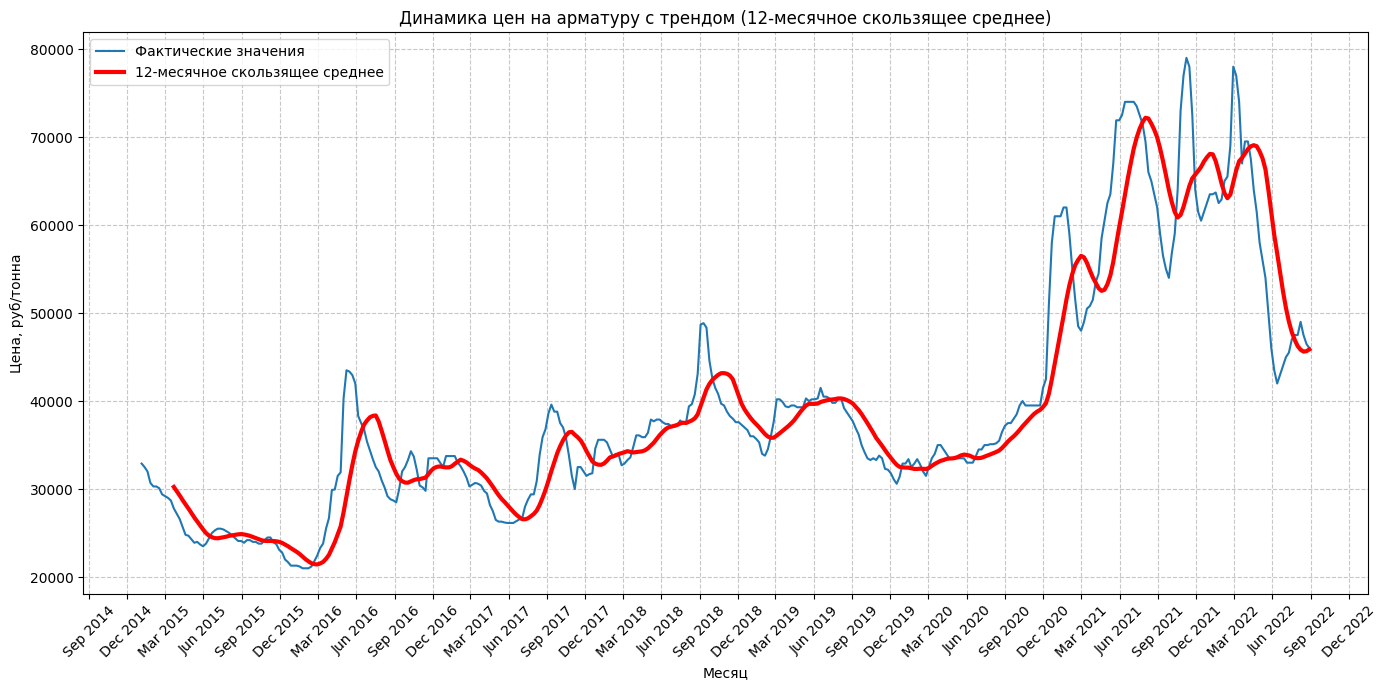

In [30]:
import matplotlib.dates as mdates

# Скользящее среднее за 12 месяцев
train['Price_MA12'] = train['Цена на арматуру'].rolling(window=12).mean()

# График тренда с помесячным отображением
plt.figure(figsize=(14, 7))
plt.plot(train['dt'], train['Цена на арматуру'], label='Фактические значения')
plt.plot(train['dt'], train['Price_MA12'], label='12-месячное скользящее среднее', color='red', linewidth=3)

# Настройка отображения дат
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # показывать каждый 3-й месяц
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # формат "Мес Год"

plt.title('Динамика цен на арматуру с трендом (12-месячное скользящее среднее)')
plt.xlabel('Месяц')
plt.ylabel('Цена, руб/тонна')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()  # автоматическая подгонка отступов
plt.show()

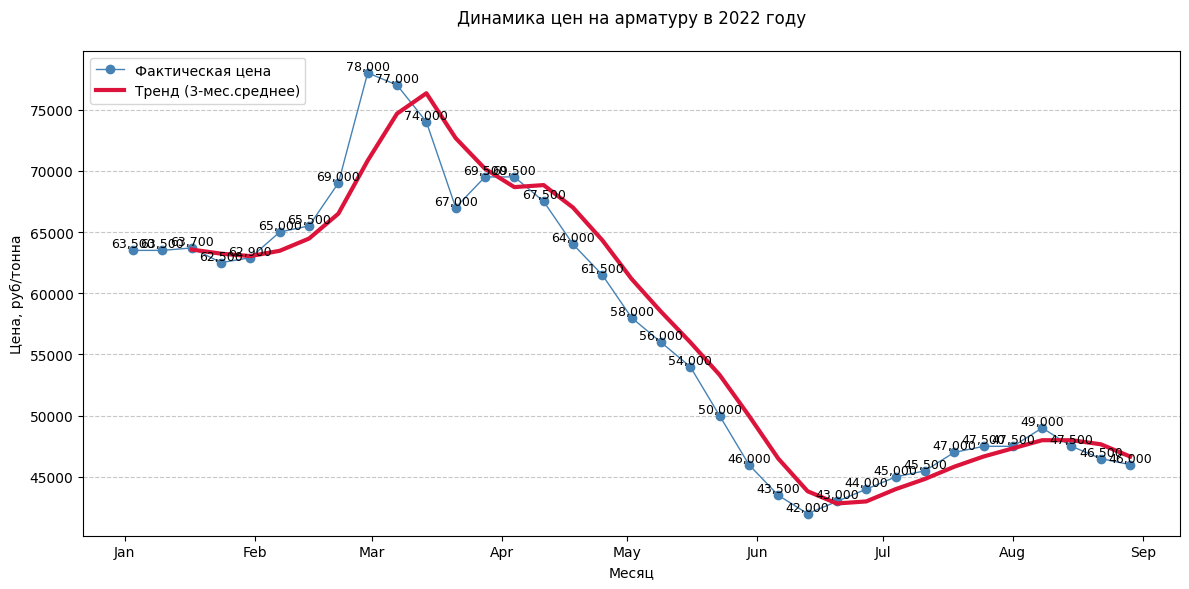

In [31]:
# Фильтруем данные за 2023 год
train_2022 = train[train['dt'].dt.year == 2022].copy()

# Рассчитываем скользящее среднее за 3 месяца для сглаживания
train_2022['Price_MA3'] = train_2022['Цена на арматуру'].rolling(window=3).mean()

# Создаем график
plt.figure(figsize=(12, 6))

# Фактические значения (точечный график + линии)
plt.plot(train_2022['dt'],
         train_2022['Цена на арматуру'],
         marker='o',
         label='Фактическая цена',
         color='steelblue',
         linewidth=1)

# Линия тренда (скользящее среднее)
plt.plot(train_2022['dt'],
         train_2022['Price_MA3'],
         label='Тренд (3-мес.среднее)',
         color='crimson',
         linewidth=3)

# Настройка отображения дат
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Формат "Янв", "Фев" и т.д.

# Добавляем подписи значений
for x, y in zip(train_2022['dt'], train_2022['Цена на арматуру']):
    plt.text(x, y, f'{y:,.0f}',
             ha='center',
             va='bottom',
             fontsize=9)

# Настройка оформления
plt.title('Динамика цен на арматуру в 2022 году', pad=20)
plt.xlabel('Месяц')
plt.ylabel('Цена, руб/тонна')
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Улучшаем читаемость
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

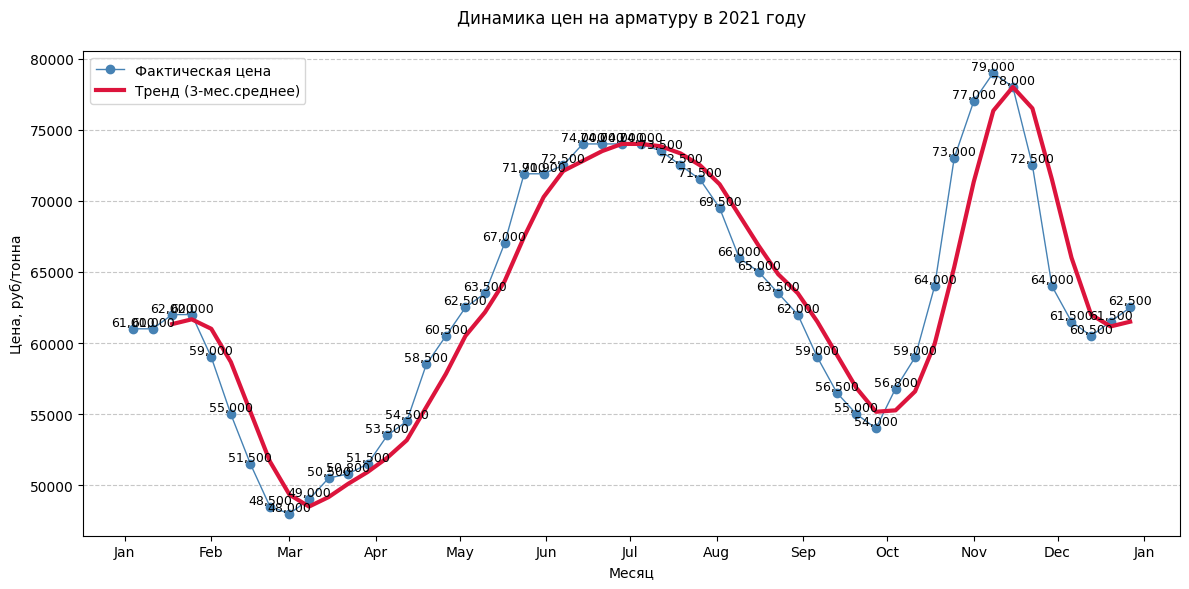

In [32]:
# Фильтруем данные за 2023 год
train_2022 = train[train['dt'].dt.year == 2021].copy()

# Рассчитываем скользящее среднее за 3 месяца для сглаживания
train_2022['Price_MA3'] = train_2022['Цена на арматуру'].rolling(window=3).mean()

# Создаем график
plt.figure(figsize=(12, 6))

# Фактические значения (точечный график + линии)
plt.plot(train_2022['dt'],
         train_2022['Цена на арматуру'],
         marker='o',
         label='Фактическая цена',
         color='steelblue',
         linewidth=1)

# Линия тренда (скользящее среднее)
plt.plot(train_2022['dt'],
         train_2022['Price_MA3'],
         label='Тренд (3-мес.среднее)',
         color='crimson',
         linewidth=3)

# Настройка отображения дат
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Формат "Янв", "Фев" и т.д.

# Добавляем подписи значений
for x, y in zip(train_2022['dt'], train_2022['Цена на арматуру']):
    plt.text(x, y, f'{y:,.0f}',
             ha='center',
             va='bottom',
             fontsize=9)

# Настройка оформления
plt.title('Динамика цен на арматуру в 2021 году', pad=20)
plt.xlabel('Месяц')
plt.ylabel('Цена, руб/тонна')
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Улучшаем читаемость
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

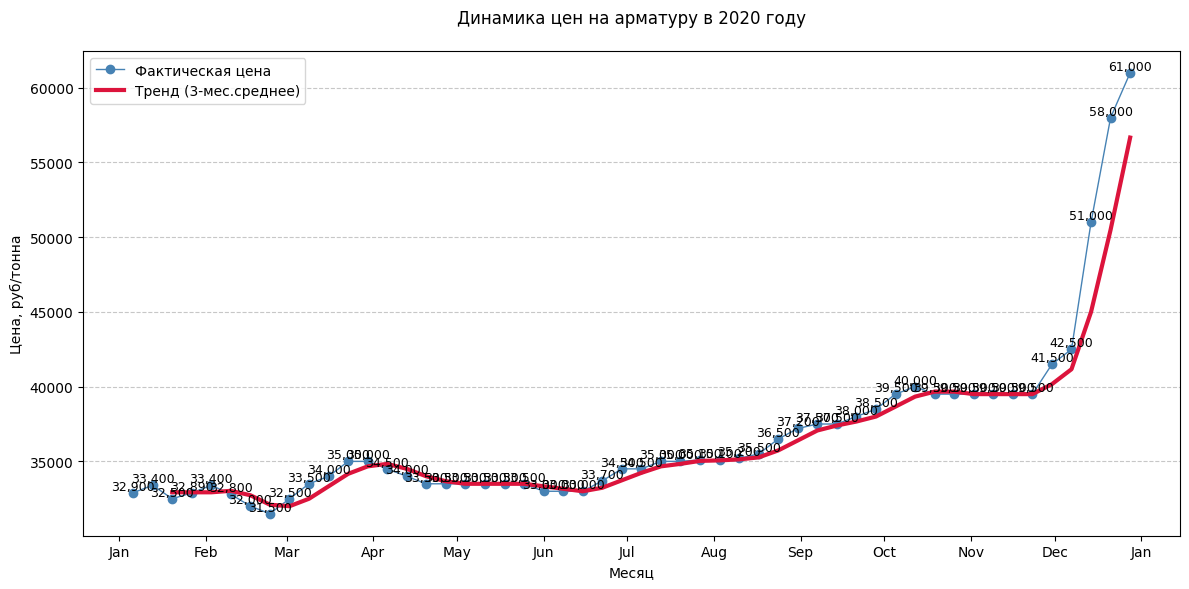

In [33]:
# Фильтруем данные за 2023 год
train_2022 = train[train['dt'].dt.year == 2020].copy()

# Рассчитываем скользящее среднее за 3 месяца для сглаживания
train_2022['Price_MA3'] = train_2022['Цена на арматуру'].rolling(window=3).mean()

# Создаем график
plt.figure(figsize=(12, 6))

# Фактические значения (точечный график + линии)
plt.plot(train_2022['dt'],
         train_2022['Цена на арматуру'],
         marker='o',
         label='Фактическая цена',
         color='steelblue',
         linewidth=1)

# Линия тренда (скользящее среднее)
plt.plot(train_2022['dt'],
         train_2022['Price_MA3'],
         label='Тренд (3-мес.среднее)',
         color='crimson',
         linewidth=3)

# Настройка отображения дат
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Формат "Янв", "Фев" и т.д.

# Добавляем подписи значений
for x, y in zip(train_2022['dt'], train_2022['Цена на арматуру']):
    plt.text(x, y, f'{y:,.0f}',
             ha='center',
             va='bottom',
             fontsize=9)

# Настройка оформления
plt.title('Динамика цен на арматуру в 2020 году', pad=20)
plt.xlabel('Месяц')
plt.ylabel('Цена, руб/тонна')
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Улучшаем читаемость
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

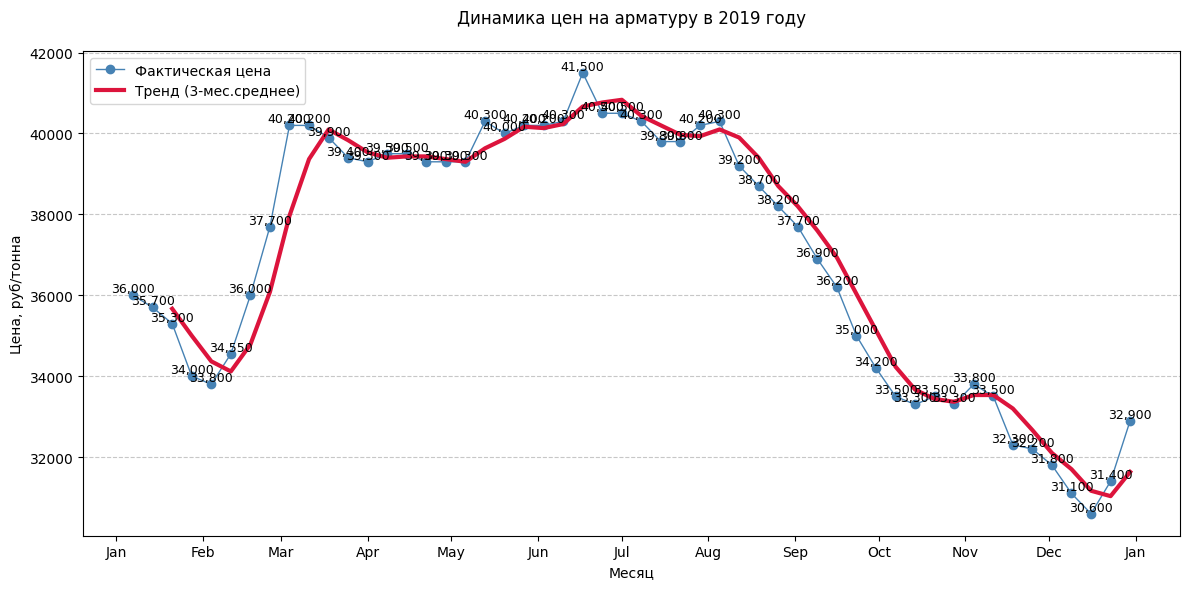

In [34]:
# Фильтруем данные за 2023 год
train_2022 = train[train['dt'].dt.year == 2019].copy()

# Рассчитываем скользящее среднее за 3 месяца для сглаживания
train_2022['Price_MA3'] = train_2022['Цена на арматуру'].rolling(window=3).mean()

# Создаем график
plt.figure(figsize=(12, 6))

# Фактические значения (точечный график + линии)
plt.plot(train_2022['dt'],
         train_2022['Цена на арматуру'],
         marker='o',
         label='Фактическая цена',
         color='steelblue',
         linewidth=1)

# Линия тренда (скользящее среднее)
plt.plot(train_2022['dt'],
         train_2022['Price_MA3'],
         label='Тренд (3-мес.среднее)',
         color='crimson',
         linewidth=3)

# Настройка отображения дат
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Формат "Янв", "Фев" и т.д.

# Добавляем подписи значений
for x, y in zip(train_2022['dt'], train_2022['Цена на арматуру']):
    plt.text(x, y, f'{y:,.0f}',
             ha='center',
             va='bottom',
             fontsize=9)

# Настройка оформления
plt.title('Динамика цен на арматуру в 2019 году', pad=20)
plt.xlabel('Месяц')
plt.ylabel('Цена, руб/тонна')
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Улучшаем читаемость
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

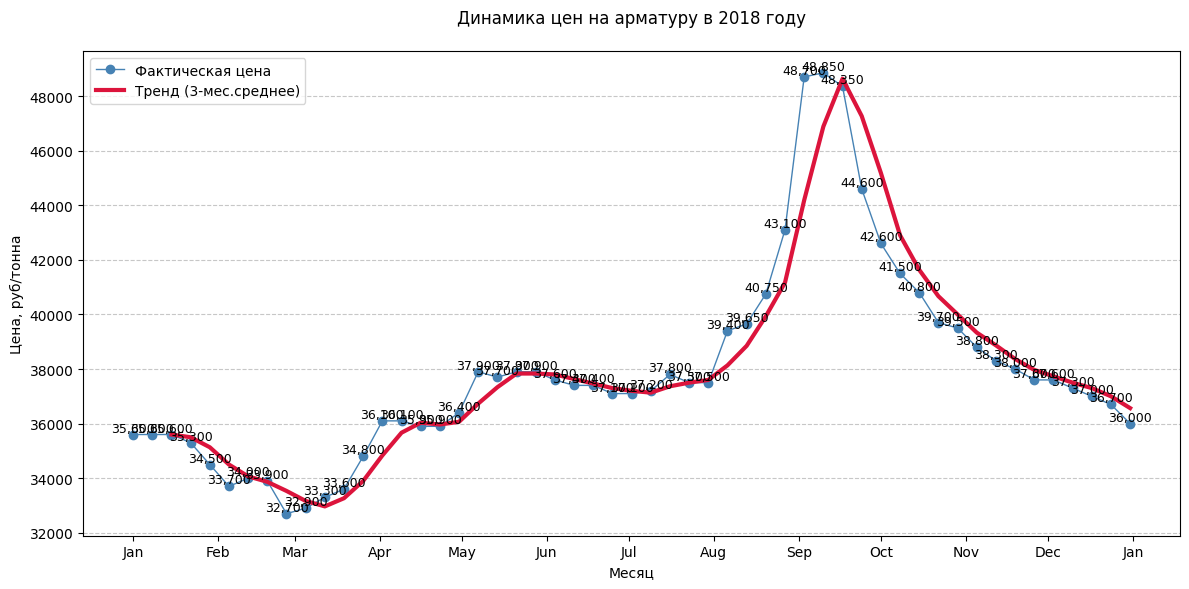

In [35]:
# Фильтруем данные за 2023 год
train_2022 = train[train['dt'].dt.year == 2018].copy()

# Рассчитываем скользящее среднее за 3 месяца для сглаживания
train_2022['Price_MA3'] = train_2022['Цена на арматуру'].rolling(window=3).mean()

# Создаем график
plt.figure(figsize=(12, 6))

# Фактические значения (точечный график + линии)
plt.plot(train_2022['dt'],
         train_2022['Цена на арматуру'],
         marker='o',
         label='Фактическая цена',
         color='steelblue',
         linewidth=1)

# Линия тренда (скользящее среднее)
plt.plot(train_2022['dt'],
         train_2022['Price_MA3'],
         label='Тренд (3-мес.среднее)',
         color='crimson',
         linewidth=3)

# Настройка отображения дат
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Формат "Янв", "Фев" и т.д.

# Добавляем подписи значений
for x, y in zip(train_2022['dt'], train_2022['Цена на арматуру']):
    plt.text(x, y, f'{y:,.0f}',
             ha='center',
             va='bottom',
             fontsize=9)

# Настройка оформления
plt.title('Динамика цен на арматуру в 2018 году', pad=20)
plt.xlabel('Месяц')
plt.ylabel('Цена, руб/тонна')
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Улучшаем читаемость
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

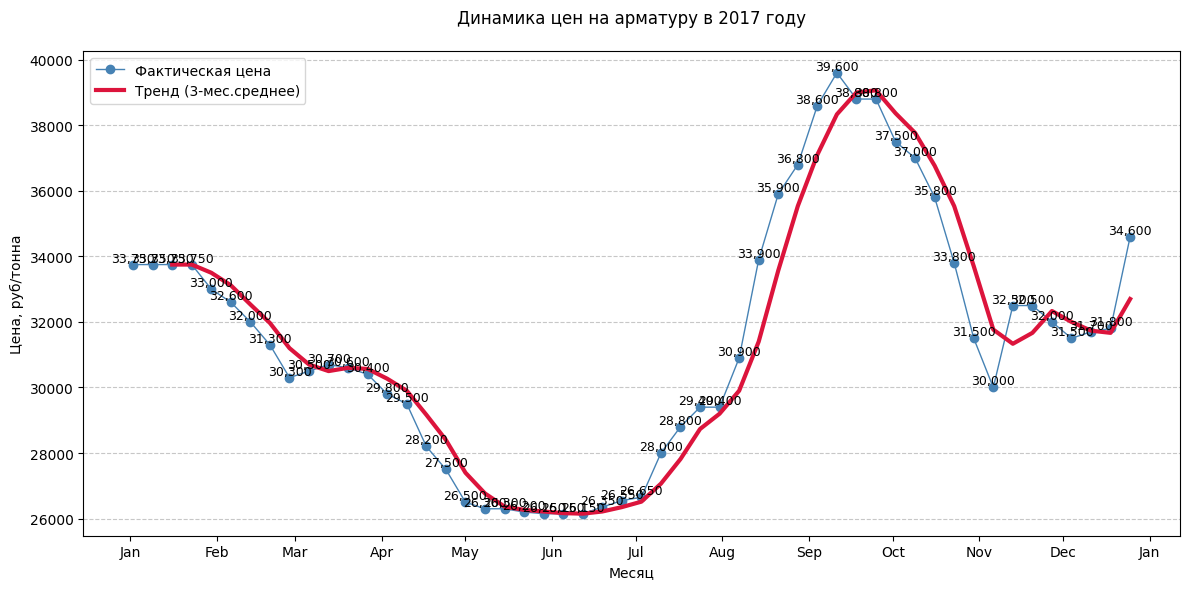

In [36]:
# Фильтруем данные за 2023 год
train_2022 = train[train['dt'].dt.year == 2017].copy()

# Рассчитываем скользящее среднее за 3 месяца для сглаживания
train_2022['Price_MA3'] = train_2022['Цена на арматуру'].rolling(window=3).mean()

# Создаем график
plt.figure(figsize=(12, 6))

# Фактические значения (точечный график + линии)
plt.plot(train_2022['dt'],
         train_2022['Цена на арматуру'],
         marker='o',
         label='Фактическая цена',
         color='steelblue',
         linewidth=1)

# Линия тренда (скользящее среднее)
plt.plot(train_2022['dt'],
         train_2022['Price_MA3'],
         label='Тренд (3-мес.среднее)',
         color='crimson',
         linewidth=3)

# Настройка отображения дат
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Формат "Янв", "Фев" и т.д.

# Добавляем подписи значений
for x, y in zip(train_2022['dt'], train_2022['Цена на арматуру']):
    plt.text(x, y, f'{y:,.0f}',
             ha='center',
             va='bottom',
             fontsize=9)

# Настройка оформления
plt.title('Динамика цен на арматуру в 2017 году', pad=20)
plt.xlabel('Месяц')
plt.ylabel('Цена, руб/тонна')
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Улучшаем читаемость
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

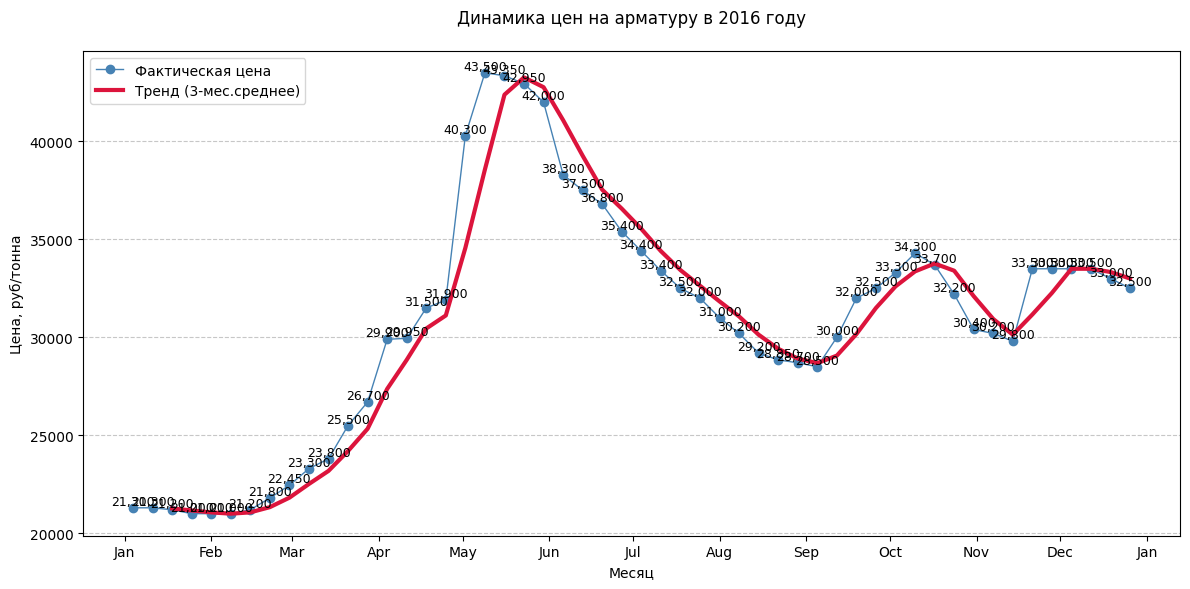

In [37]:
# Фильтруем данные за 2023 год
train_2022 = train[train['dt'].dt.year == 2016].copy()

# Рассчитываем скользящее среднее за 3 месяца для сглаживания
train_2022['Price_MA3'] = train_2022['Цена на арматуру'].rolling(window=3).mean()

# Создаем график
plt.figure(figsize=(12, 6))

# Фактические значения (точечный график + линии)
plt.plot(train_2022['dt'],
         train_2022['Цена на арматуру'],
         marker='o',
         label='Фактическая цена',
         color='steelblue',
         linewidth=1)

# Линия тренда (скользящее среднее)
plt.plot(train_2022['dt'],
         train_2022['Price_MA3'],
         label='Тренд (3-мес.среднее)',
         color='crimson',
         linewidth=3)

# Настройка отображения дат
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Формат "Янв", "Фев" и т.д.

# Добавляем подписи значений
for x, y in zip(train_2022['dt'], train_2022['Цена на арматуру']):
    plt.text(x, y, f'{y:,.0f}',
             ha='center',
             va='bottom',
             fontsize=9)

# Настройка оформления
plt.title('Динамика цен на арматуру в 2016 году', pad=20)
plt.xlabel('Месяц')
plt.ylabel('Цена, руб/тонна')
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Улучшаем читаемость
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

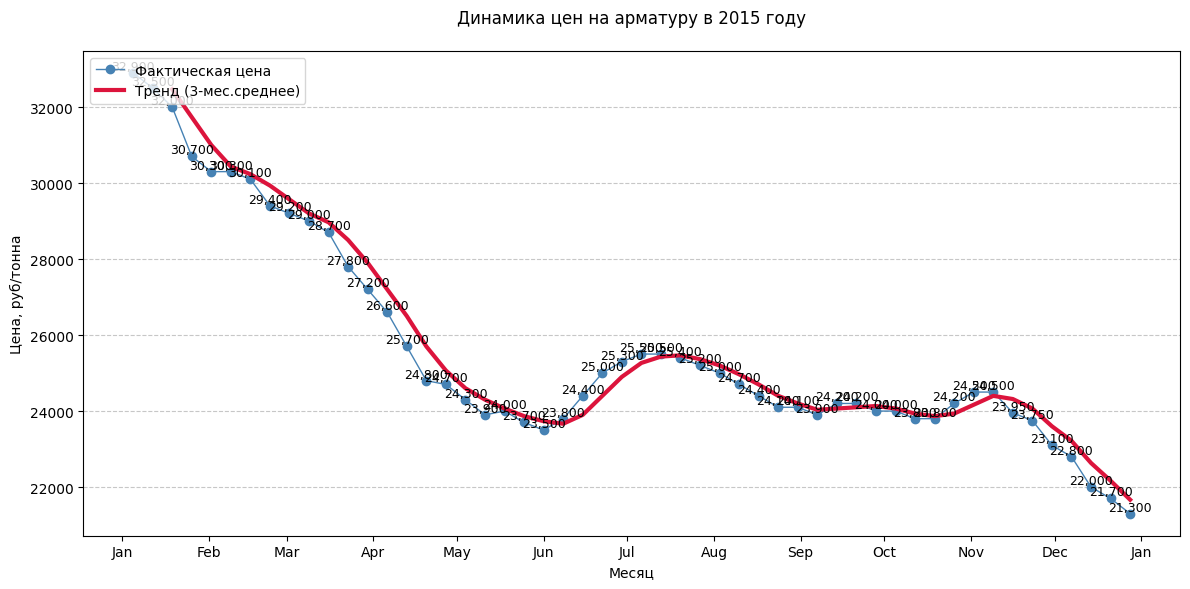

In [38]:
# Фильтруем данные за 2023 год
train_2022 = train[train['dt'].dt.year == 2015].copy()

# Рассчитываем скользящее среднее за 3 месяца для сглаживания
train_2022['Price_MA3'] = train_2022['Цена на арматуру'].rolling(window=3).mean()

# Создаем график
plt.figure(figsize=(12, 6))

# Фактические значения (точечный график + линии)
plt.plot(train_2022['dt'],
         train_2022['Цена на арматуру'],
         marker='o',
         label='Фактическая цена',
         color='steelblue',
         linewidth=1)

# Линия тренда (скользящее среднее)
plt.plot(train_2022['dt'],
         train_2022['Price_MA3'],
         label='Тренд (3-мес.среднее)',
         color='crimson',
         linewidth=3)

# Настройка отображения дат
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Формат "Янв", "Фев" и т.д.

# Добавляем подписи значений
for x, y in zip(train_2022['dt'], train_2022['Цена на арматуру']):
    plt.text(x, y, f'{y:,.0f}',
             ha='center',
             va='bottom',
             fontsize=9)

# Настройка оформления
plt.title('Динамика цен на арматуру в 2015 году', pad=20)
plt.xlabel('Месяц')
plt.ylabel('Цена, руб/тонна')
plt.legend(loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Улучшаем читаемость
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [39]:

# Подготовка тренировочной выборки
df_train = pd.DataFrame()
df_train['dt'] = pd.to_datetime(train['dt'])
df_train['Price'] = train['Цена на арматуру']
df_train['istest'] = 0

# Подготовка тестовой выборки
df_test = pd.DataFrame()
df_test['dt'] = pd.to_datetime(test['dt'])
df_test['Price'] = test['Цена на арматуру']
df_test['istest'] = 1

# Конкатинируем в один датасет с метрой `istest`
raw = pd.concat((df_train, df_test)).reset_index(drop=True)


# Посмотрим на тип переменных
raw.dtypes

# Создадим матрицы со сдвигом, то есть сделаем так чтобы значение
# цены на следующую неделю являлось "неизвестным для модели"
X = raw.drop(columns=['Price']).iloc[:-1, :]
y = raw['Price'].values[1:]
X['Price_target'] = y
X['Price_source'] = raw['Price'].values[:-1]

# Подсчитаем разницу между текущим и прошлым значением цены на покупку арматуры
price_diff = X['Price_source'] - X['Price_target']
y = X['Price_target']
X = X.drop(columns=['Price_target', 'dt'])

# Удаляем первую строку
X = X.drop([0])

# Добавляем разницу в цене
X['Price_Diff'] = price_diff.values[:-1]
X

istest  Price_source  Price_Diff
1         0         32500         400
2         0         32000         500
3         0         30700        1300
4         0         30300         400
5         0         30300           0
..      ...           ...         ...
422       1         44500       -1700
423       1         44500           0
424       1         46000       -1500
425       1         49200       -3200
426       1         53700       -4500

[426 rows x 3 columns]

In [40]:
print(f"X shape: {X.shape}")  # Количество строк и столбцов в X
print(f"y shape: {y.shape}")  # Количество элементов в y

X shape: (426, 3)
y shape: (427,)


In [41]:
y = y[X.index]  # Пересинхронизируем индексы
X_for_train = (X['istest'] == 0)

X_train, X_holdout, y_train, y_holdout = train_test_split(
    X[X_for_train].drop(columns=['istest']),
    y[X_for_train],
    test_size=0.2,
    shuffle=False
)



# Разделяем данные: 80% - для обучения, 20% - для валидации
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# Проверим размеры выборок
print(f"X_train: {X_train.shape}, X_holdout: {X_holdout.shape}")
print(f"y_train: {y_train.shape}, y_holdout: {y_holdout.shape}")


X_train: (340, 3), X_holdout: (86, 3)
y_train: (340,), y_holdout: (86,)


0:	learn: 6582.4852968	test: 20812.4186128	best: 20812.4186128 (0)	total: 51.6ms	remaining: 51.6s
1:	learn: 6416.5935357	test: 20284.7242060	best: 20284.7242060 (1)	total: 56.8ms	remaining: 28.3s
2:	learn: 6254.2779248	test: 19930.2041768	best: 19930.2041768 (2)	total: 87ms	remaining: 28.9s
3:	learn: 6071.0506366	test: 19442.4493390	best: 19442.4493390 (3)	total: 94.5ms	remaining: 23.5s
4:	learn: 5927.4968120	test: 19164.4178972	best: 19164.4178972 (4)	total: 100ms	remaining: 19.9s
5:	learn: 5807.4137912	test: 18980.3354901	best: 18980.3354901 (5)	total: 101ms	remaining: 16.7s
6:	learn: 5662.0228044	test: 18675.2417273	best: 18675.2417273 (6)	total: 106ms	remaining: 15s
7:	learn: 5512.6798807	test: 18235.9797880	best: 18235.9797880 (7)	total: 110ms	remaining: 13.7s
8:	learn: 5380.9908855	test: 18000.0859380	best: 18000.0859380 (8)	total: 114ms	remaining: 12.6s
9:	learn: 5267.3640676	test: 17867.4464779	best: 17867.4464779 (9)	total: 119ms	remaining: 11.7s
10:	learn: 5125.4997587	test: 

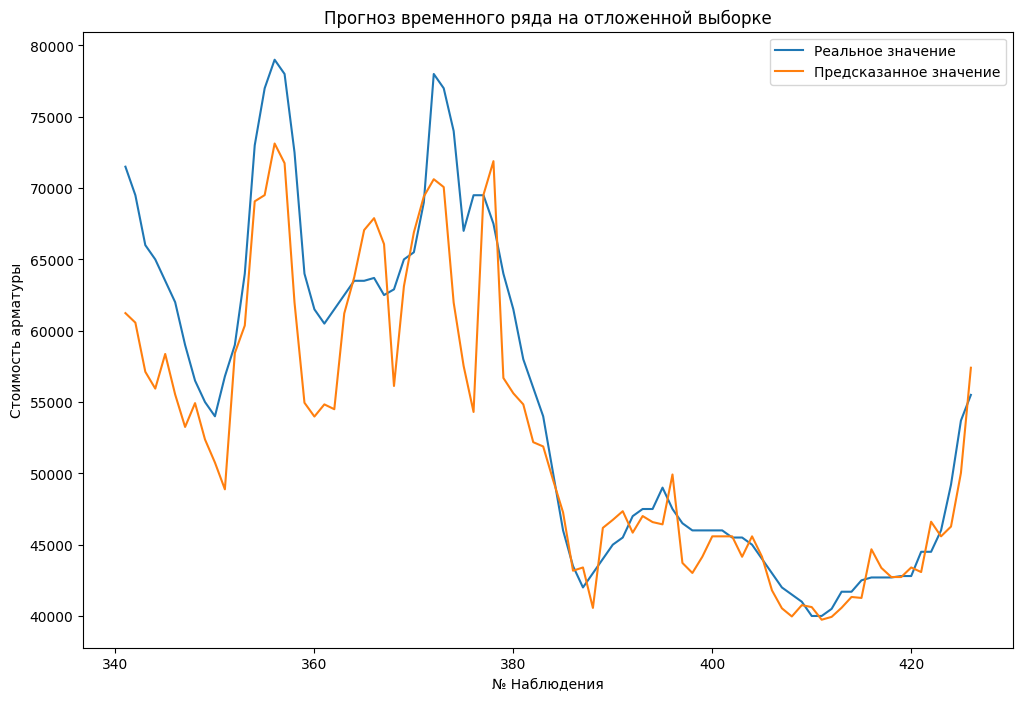

In [42]:
model0 = CatBoostRegressor(iterations=1000, depth = 10, loss_function='MAE' , learning_rate = 0.03,  eval_metric="MAE",
                           early_stopping_rounds = 50 , random_state=42

                        )
model1 = CatBoostRegressor(iterations=1000, depth = 10, loss_function='MAE' , learning_rate = 0.03,  eval_metric="MAE",
                           early_stopping_rounds = 100 , random_state=52

                        )
model2 = CatBoostRegressor(iterations=1000, depth = 10, loss_function='MAE' , learning_rate = 0.05,  eval_metric="MAE",
                           early_stopping_rounds = 100 , random_state=117

                        )
model0.fit(X_train, y_train, eval_set=(X_holdout , y_holdout)

)
model1.fit(X_train, y_train, eval_set=(X_holdout , y_holdout)

)
model2.fit(X_train, y_train, eval_set=(X_holdout , y_holdout)

)
ypred = (model0.predict(X_holdout) +
         model1.predict(X_holdout) +
         model2.predict(X_holdout)) / 3

result = pd.DataFrame({'real': y_holdout, 'pred': ypred})
result['error'] = result['real'] - result['pred']
result = result.sort_index()
result.tail(12)

from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=100)


plt.plot(result['real'], label='Реальное значение');
plt.plot(result['pred'], label='Предсказанное значение');
plt.title('Прогноз временного ряда на отложенной выборке')
plt.xlabel('№ Наблюдения')
plt.ylabel('Стоимость арматуры')
plt.legend();


data_for_test = X[X['istest'] == 1]
ypred = (model0.predict(data_for_test) +
         model1.predict(data_for_test) +
         model2.predict(data_for_test)) / 3



result = pd.DataFrame({'real': y[X['istest'] == 1][1:],
              'pred': ypred[:-1]})
result['error'] = result['real'] - result['pred']
result.tail(12)


from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(result['real'], result['pred'])
mse = mean_squared_error(result['real'], result['pred'])

print(f"MAE: {mae}")
print(f"MSE: {mse}")
rmse = mse ** 0.5
print(f"RMSE: {rmse}")



In [43]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
import numpy as np
import joblib

# Используем TimeSeriesSplit для корректной оценки модели
tscv = TimeSeriesSplit(n_splits=5)

# Проведение кросс-валидации
mae_scores = []
rmse_scores = []
r2_scores = []

for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]


    model1.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100, early_stopping_rounds=50)
    preds = model1.predict(X_val)

    mae_scores.append(mean_absolute_error(y_val, preds))
    rmse_scores.append(np.sqrt(mean_squared_error(y_val, preds)))
    r2_scores.append(r2_score(y_val, preds))

print(f'Mean MAE: {np.mean(mae_scores):.4f}')
print(f'Mean RMSE: {np.mean(rmse_scores):.4f}')
print(f'Mean R²: {np.mean(r2_scores):.4f}')

# Финальное обучение модели
model1.fit(X, y)

# Прогнозирование цен на ближайшие 6 недель
future_weeks = 6
last_X = X.iloc[-1:].copy()
price_forecast = []

for _ in range(future_weeks):
    pred_price = model1.predict(last_X)[0]
    price_forecast.append(pred_price)
    last_X.iloc[0, X.columns.get_loc('Price_source')] = pred_price  # Подстановка предсказания

# Определение оптимального N
N = 1
for i in range(1, future_weeks):
    if price_forecast[i] > price_forecast[i - 1]:
        break
    N += 1

print(f'Рекомендуемый объем закупки на {N} недель')

# Сохранение модели
joblib.dump(model1, 'catboost_model.pkl')


0:	learn: 2979.0915500	test: 7234.9295801	best: 7234.9295801 (0)	total: 4.03ms	remaining: 4.03s
100:	learn: 415.3437672	test: 2099.1872094	best: 2098.2082003 (99)	total: 227ms	remaining: 2.02s
200:	learn: 144.0063445	test: 1859.5618275	best: 1855.9668868 (186)	total: 556ms	remaining: 2.21s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1855.966887
bestIteration = 186

Shrink model to first 187 iterations.
0:	learn: 4172.2957760	test: 7897.5281703	best: 7897.5281703 (0)	total: 5.91ms	remaining: 5.9s
100:	learn: 584.3546709	test: 2158.2314675	best: 2158.2314675 (100)	total: 470ms	remaining: 4.19s
200:	learn: 280.6640609	test: 1502.7447345	best: 1502.7447345 (200)	total: 852ms	remaining: 3.39s
300:	learn: 196.2770583	test: 1479.5282319	best: 1477.2770953 (284)	total: 1.18s	remaining: 2.73s
400:	learn: 157.5884847	test: 1472.1225447	best: 1471.2603491 (385)	total: 1.68s	remaining: 2.51s
500:	learn: 136.3559318	test: 1448.1180404	best: 1446.5952115 (458)	total: 2.29s	rema

<ipython-input-43-6f7d61889256>:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '55501.658554449656' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  last_X.iloc[0, X.columns.get_loc('Price_source')] = pred_price  # Подстановка предсказания


['catboost_model.pkl']

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from catboost import CatBoostRegressor, Pool
!pip install optuna
import optuna
import joblib

df = raw.copy()
df['Date'] = pd.to_datetime(df['dt'])  # Преобразуем дату
df['Week'] = df['dt'].dt.isocalendar().week  # Добавляем номер недели
df['Year'] = df['dt'].dt.year  # Добавляем год

# Логарифмируем цены
if 'Price' in df.columns:
    df['Log_Price'] = np.log1p(df['Price'])

# Генерируем лаги (цены за прошлые недели)
for lag in range(1, 7):
    df[f'Lag_{lag}'] = df['Log_Price'].shift(lag)

df.dropna(inplace=True)  # Убираем NaN после лагов

X = df.drop(columns=['Date', 'Price', 'Log_Price'])
y = df['Log_Price']

# Разбивка по времени
tscv = TimeSeriesSplit(n_splits=5)

# Оптимизация гиперпараметров с Optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000, step=50),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.1),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-5, 10),
        "loss_function": "RMSE",
        "random_seed": 42,
        "verbose": 0
    }
    model = CatBoostRegressor(**params)
    scores = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_absolute_error')
    return -np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  # Можно увеличить для лучшего поиска

# Лучшие параметры
best_params = study.best_params
print("Лучшие параметры:", best_params)

# Обучение финальной модели
model = CatBoostRegressor(**best_params)
model.fit(X, y)

# Сохранение модели
joblib.dump(model, "catboost_optimized.pkl")
print("Модель сохранена!")


[I 2025-03-25 05:55:08,656] A new study created in memory with name: no-name-4a7407d5-10c3-4bd0-a06f-9775243f5b45
<ipython-input-44-1eeceda84031>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.1),
<ipython-input-44-1eeceda84031>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-5, 10),
[I 2025-03-25 05:55:10,837] Trial 0 finished with value: 0.12014035130046792 and parameters: {'iterations': 550, 'depth': 5, 'learning_rate': 0.025869032675807847, 'l2_leaf_reg': 0.0007267728497026716}. Best is trial 0 with value: 0.12014035130046792.
<ipython-i

Лучшие параметры: {'iterations': 900, 'depth': 4, 'learning_rate': 0.008124366836285648, 'l2_leaf_reg': 0.000124931305885054}
0:	learn: 0.3034554	total: 818us	remaining: 736ms
1:	learn: 0.3013946	total: 1.58ms	remaining: 710ms
2:	learn: 0.2994137	total: 2.34ms	remaining: 699ms
3:	learn: 0.2975336	total: 3.04ms	remaining: 682ms
4:	learn: 0.2954074	total: 3.69ms	remaining: 661ms
5:	learn: 0.2932898	total: 4.31ms	remaining: 642ms
6:	learn: 0.2912290	total: 4.95ms	remaining: 632ms
7:	learn: 0.2891652	total: 5.59ms	remaining: 623ms
8:	learn: 0.2871132	total: 6.22ms	remaining: 616ms
9:	learn: 0.2850043	total: 6.86ms	remaining: 611ms
10:	learn: 0.2829302	total: 7.49ms	remaining: 605ms
11:	learn: 0.2810105	total: 8.19ms	remaining: 606ms
12:	learn: 0.2793003	total: 8.94ms	remaining: 610ms
13:	learn: 0.2774096	total: 9.66ms	remaining: 611ms
14:	learn: 0.2754558	total: 10.3ms	remaining: 606ms
15:	learn: 0.2737957	total: 10.9ms	remaining: 604ms
16:	learn: 0.2719957	total: 11.6ms	remaining: 602ms
1

In [45]:
# Обучение модели с лучшими параметрами
best_params = {
    "iterations": 300,
    "depth": 4,
    "learning_rate": 0.024223716962088065,
    "l2_leaf_reg": 1.3583856343793253e-05,
    "loss_function": "MAE",
    "random_seed": 42
}

model_optimized = CatBoostRegressor(**best_params)
model_optimized.fit(X, y, verbose=100)

# Оценка качества модели
from sklearn.model_selection import cross_val_score
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(model_optimized, X, y, cv=tscv, scoring='neg_mean_absolute_error')

print(f"Mean MAE: {-np.mean(scores):.4f}")

0:	learn: 0.2303060	total: 825us	remaining: 247ms
100:	learn: 0.0495658	total: 75.9ms	remaining: 150ms
200:	learn: 0.0323000	total: 146ms	remaining: 71.9ms
299:	learn: 0.0255772	total: 215ms	remaining: 0us
0:	learn: 0.1251471	total: 378us	remaining: 113ms
1:	learn: 0.1229096	total: 676us	remaining: 101ms
2:	learn: 0.1208717	total: 957us	remaining: 94.8ms
3:	learn: 0.1186774	total: 1.23ms	remaining: 91.4ms
4:	learn: 0.1167350	total: 1.52ms	remaining: 89.5ms
5:	learn: 0.1151844	total: 1.81ms	remaining: 88.6ms
6:	learn: 0.1125641	total: 2.08ms	remaining: 87ms
7:	learn: 0.1100956	total: 2.34ms	remaining: 85.5ms
8:	learn: 0.1082365	total: 2.6ms	remaining: 84.2ms
9:	learn: 0.1070825	total: 2.85ms	remaining: 82.5ms
10:	learn: 0.1056313	total: 3.08ms	remaining: 81ms
11:	learn: 0.1032835	total: 3.33ms	remaining: 80ms
12:	learn: 0.1010956	total: 3.61ms	remaining: 79.6ms
13:	learn: 0.0990826	total: 3.8ms	remaining: 77.6ms
14:	learn: 0.0968884	total: 4.03ms	remaining: 76.7ms
15:	learn: 0.0948825	t

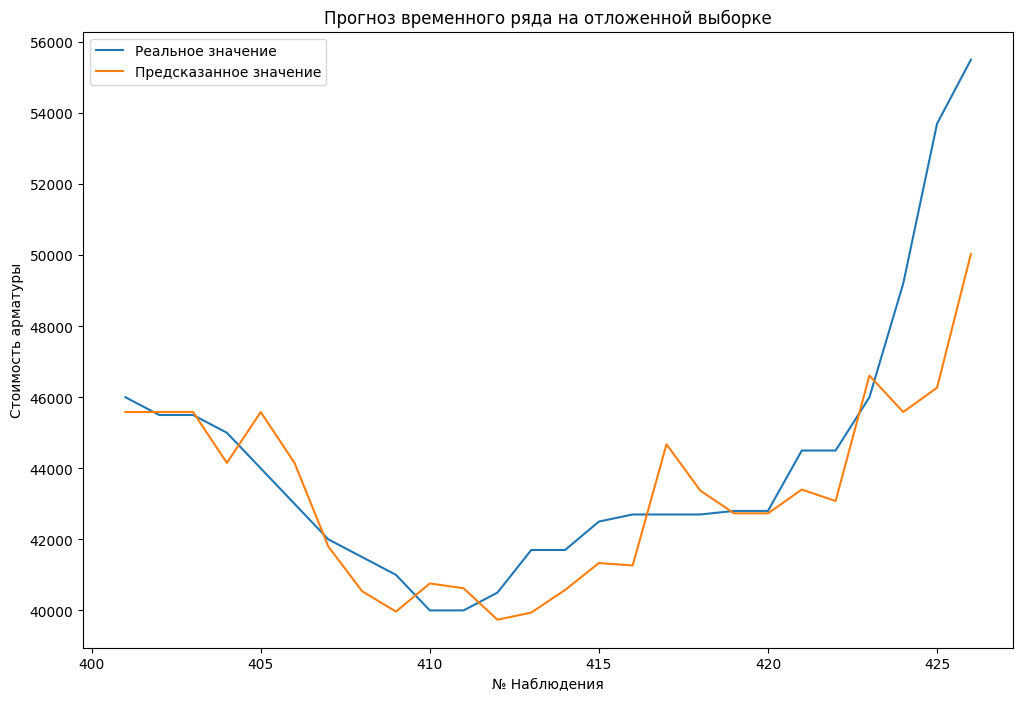

In [46]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=100)


plt.plot(result['real'], label='Реальное значение');
plt.plot(result['pred'], label='Предсказанное значение');
plt.title('Прогноз временного ряда на отложенной выборке')
plt.xlabel('№ Наблюдения')
plt.ylabel('Стоимость арматуры')
plt.legend();


In [47]:
import joblib
import pandas as pd
from datetime import datetime

# Загрузка модели из файла
model = joblib.load('/content/catboost_model.pkl')

# Проверка ожидаемых признаков
print("Ожидаемые признаки модели:", model.feature_names_)


Ожидаемые признаки модели: ['istest', 'Price_source', 'Price_Diff']


In [48]:


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Предположим, что result['real'] и result['pred'] содержат реальные и предсказанные значения
mae = mean_absolute_error(result['real'], result['pred'])
mse = mean_squared_error(result['real'], result['pred'])
rmse = mse ** 0.5
r2 = r2_score(result['real'], result['pred'])

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 1401.151734288064
MSE: 4704031.206943605
RMSE: 2168.877868148321
R2: 0.6528526689605993


In [49]:
mak = pd.read_excel('Макропоказатели.xlsx')
price = pd.read_excel('Цены на сырье.xlsx')
mak

dt  Базовый индекс потребительских цен на товары и услуги  \
0    2016-01-31                                                NaN       
1    2016-02-29                                                NaN       
2    2016-03-31                                                NaN       
3    2016-04-30                                                NaN       
4    2016-05-31                                                NaN       
...         ...                                                ...       
1667 2023-06-10                                                NaN       
1668 2023-06-13                                                NaN       
1669 2023-06-14                                                NaN       
1670 2023-06-15                                                NaN       
1671 2023-06-16                                                NaN       

      Ключевая ставка  Курс доллара  
0                 NaN           NaN  
1                 NaN           NaN  
2                 NaN           NaN  
3                 NaN           NaN  
4                 NaN           NaN  
...               ...           ...  
1667              NaN       82.6417  
1668              7.5           NaN  
1669              7.5       83.6405  
1670              7.5       84.3249  
1671              7.5       83.9611  

[1672 rows x 4 columns]

In [50]:
# Преобразуем столбец с датой в формат datetime
mak['dt'] = pd.to_datetime(mak['dt'])
price['dt'] = pd.to_datetime(price['dt'])

# Объединяем данные по дате
merged_data = pd.merge(mak, price, on='dt', how='outer')

# Сортируем данные по дате
merged_data = merged_data.sort_values(by='dt').reset_index(drop=True)

# Посмотрим на результат
merged_data.head()

dt  Базовый индекс потребительских цен на товары и услуги  \
0 2015-02-09                                                NaN       
1 2015-02-16                                                NaN       
2 2015-02-23                                                NaN       
3 2015-03-02                                                NaN       
4 2015-03-09                                                NaN       

   Ключевая ставка  Курс доллара  \
0              NaN           NaN   
1              NaN           NaN   
2              NaN           NaN   
3              NaN           NaN   
4              NaN           NaN   

   Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС  \
0                                             3850.0                  
1                                             3850.0                  
2                                             3850.0                  
3                                             3850.0                  
4                                             4400.0                  

   Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т  \
0                                     228.0   
1                                     206.0   
2                                     207.0   
3                                     214.0   
4                                     232.0   

   Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС  \
0                                       12344.0   
1                                       12271.0   
2                                       12645.0   
3                                       12696.0   
4                                       12916.0   

   Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС  \
0                                           10009.0   
1                                           10432.0   
2                                           11981.0   
3                                           11912.0   
4                                           12061.0   

   Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС  \
0                                            12728.0    
1                                            12852.0    
2                                            13034.0    
3                                            12910.0    
4                                            12964.0    

   ЖРС_Китай Iron ore fines Fe 62%, CFR  ...  \
0                                  62.0  ...   
1                                  63.0  ...   
2                                  64.0  ...   
3                                  63.0  ...   
4                                  61.0  ...   

   Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС  \
0                                                NaN      
1                                                NaN      
2                                                NaN      
3                                                NaN      
4                                                NaN      

   Чугун_CFR Турция, $/т  \
0                    NaN   
1                    NaN   
2                    NaN   
3                    NaN   
4                    NaN   

   ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС  \
0                                                NaN                           
1                                                NaN                           
2                                                NaN                           
3                                             3540.0                           
4                                             3540.0                           

   ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС  \
0                                                NaN                            
1                                                NaN                            
2                                                NaN                            
3                                             2097.0     

In [51]:
# Объединяем
merged_data = pd.merge(mak, raw, on='dt', how='outer')

# Объединяем результат
merged_data = pd.merge(merged_data, price, on='dt', how='outer')

# Сортируем данные по дате
merged_data = merged_data.sort_values(by='dt').reset_index(drop=True)

# Посмотрим на результат
merged_data.head()

dt  Базовый индекс потребительских цен на товары и услуги  \
0 2015-01-05                                                NaN       
1 2015-01-12                                                NaN       
2 2015-01-19                                                NaN       
3 2015-01-26                                                NaN       
4 2015-02-02                                                NaN       

   Ключевая ставка  Курс доллара    Price  istest  \
0              NaN           NaN  32900.0     0.0   
1              NaN           NaN  32500.0     0.0   
2              NaN           NaN  32000.0     0.0   
3              NaN           NaN  30700.0     0.0   
4              NaN           NaN  30300.0     0.0   

   Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС  \
0                                                NaN                  
1                                                NaN                  
2                                                NaN                  
3                                                NaN                  
4                                                NaN                  

   Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   

   Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС  \
0                                           NaN   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

   Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС  ...  \
0                                               NaN  ...   
1                                               NaN  ...   
2                                               NaN  ...   
3                                               NaN  ...   
4                                               NaN  ...   

   Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС  \
0                                                NaN      
1                                                NaN      
2                                                NaN      
3                                                NaN      
4                                                NaN      

   Чугун_CFR Турция, $/т  \
0                    NaN   
1                    NaN   
2                    NaN   
3                    NaN   
4                    NaN   

   ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС  \
0                                                NaN                           
1                                                NaN                           
2                                                NaN                           
3                                                NaN                           
4                                                NaN                           

   ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС  \
0                                                NaN                            
1                                                NaN                            
2                                                NaN                            
3                                                NaN                            
4                                                NaN                            

   ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС  \
0                                                NaN                          
1                                                NaN                          
2                                                NaN                          
3                                                NaN                          

<Axes: >

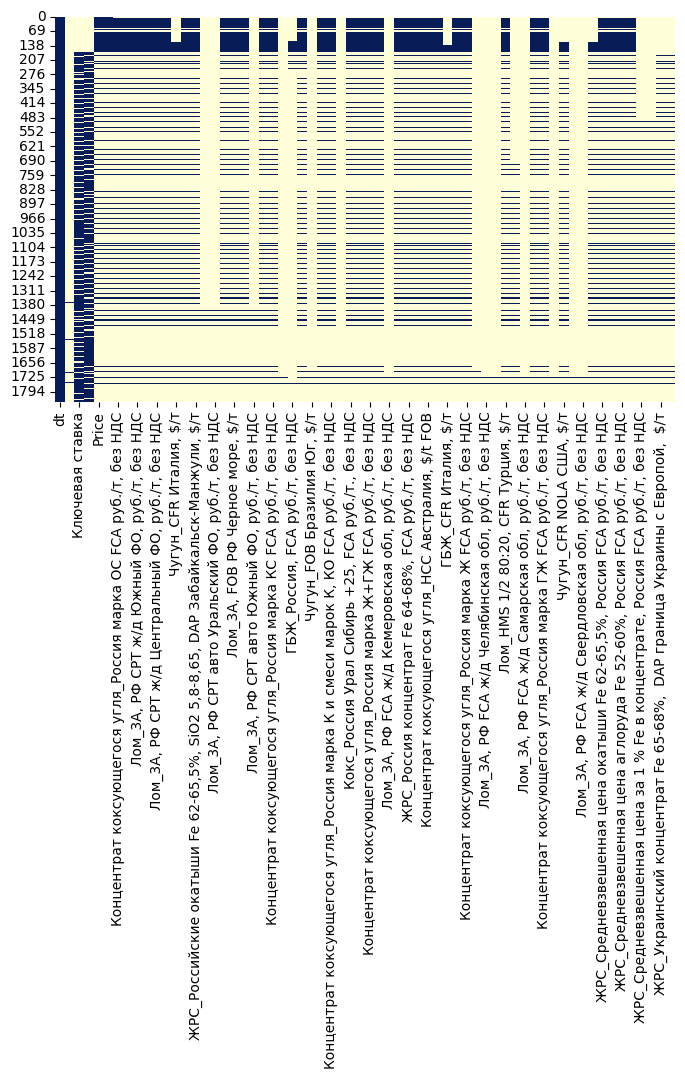

In [52]:
plt.figure(figsize = (8,5)) #пропуски
sns.heatmap(merged_data.isnull(),cmap="YlGnBu_r",cbar=False)

In [53]:
# Вычисляем порог для thresh
thresh = int(0.5 * len(merged_data.columns)) + 1

# Удаляем строки, где больше 50% значений пропущено
merged_df_cleaned = merged_data.dropna(thresh=thresh)

# Проверяем результат
print(f"Исходный размер данных: {merged_data.shape}")
print(f"Размер данных после удаления: {merged_df_cleaned.shape}")

Исходный размер данных: (1843, 64)
Размер данных после удаления: (423, 64)


<Axes: >

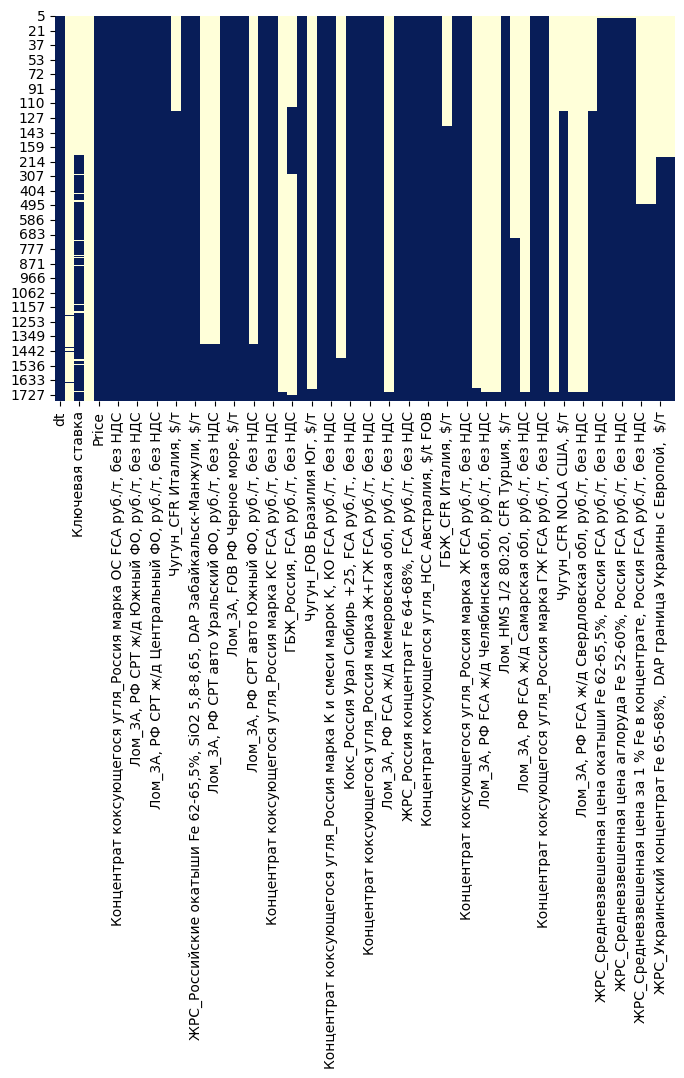

In [54]:
plt.figure(figsize = (8,5)) #пропуски
sns.heatmap(merged_df_cleaned.isnull(),cmap="YlGnBu_r",cbar=False)

Интерполяция — это метод заполнения пропущенных значений (NaN) на основе известных значений. В Pandas метод interpolate() позволяет заполнить пропуски, используя различные стратегии интерполяции. По умолчанию используется линейная интерполяция, которая предполагает, что значения между известными точками изменяются линейно

<Axes: >

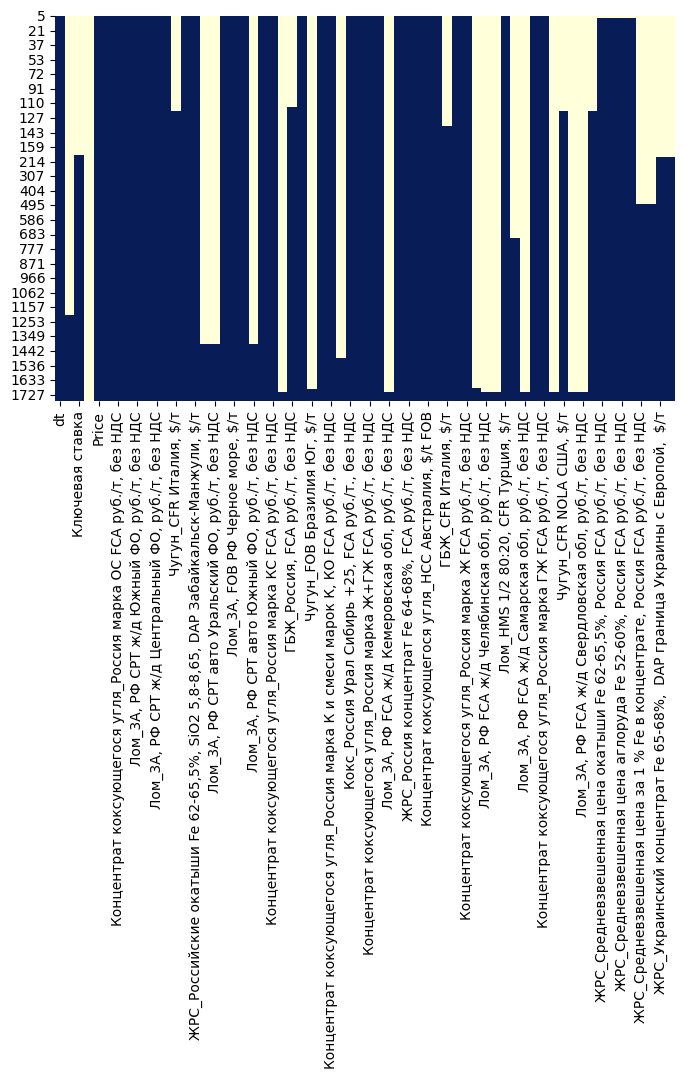

In [55]:
merged_df_cleaned = merged_df_cleaned.interpolate()
plt.figure(figsize = (8,5)) #пропуски
sns.heatmap(merged_df_cleaned.isnull(),cmap="YlGnBu_r",cbar=False)

<Axes: >

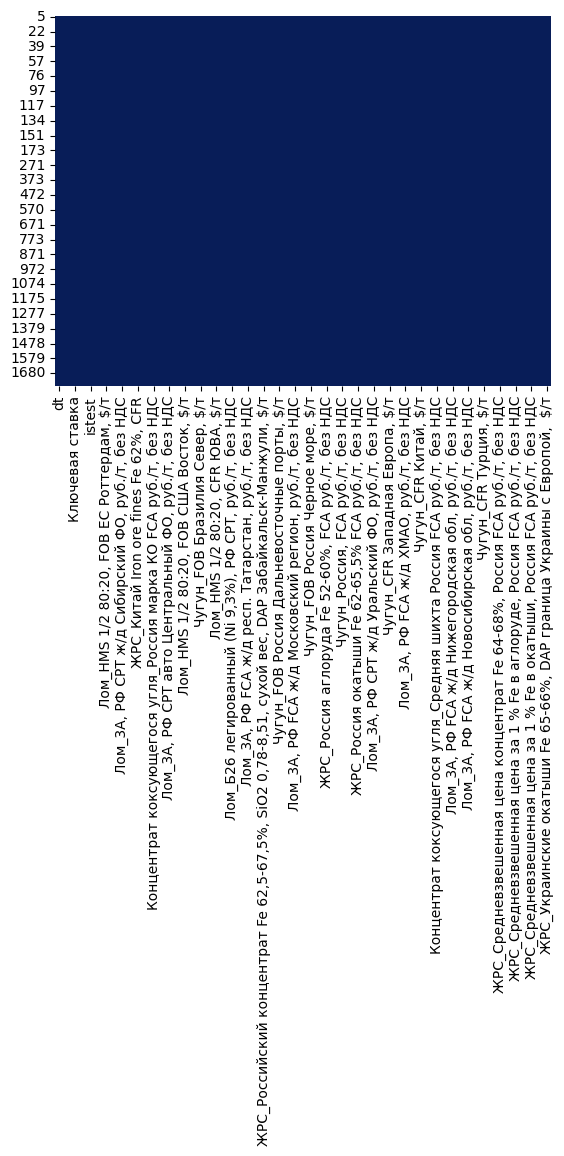

In [56]:
# Заполняем пропуски вперед и назад
merged_df_cleaned = merged_df_cleaned.interpolate().ffill().bfill()
merged_df_cleaned = merged_df_cleaned.dropna(axis=1)
sns.heatmap(merged_df_cleaned.isnull(),cmap="YlGnBu_r",cbar=False)


In [57]:
# Разделяем данные на тренировочные и тестовые
split_index = int(0.8 * len(merged_df_cleaned))  # 80% тренировочных данных
train_data = merged_df_cleaned.iloc[:split_index]
test_data = merged_df_cleaned.iloc[split_index:]

# Проверяем размеры выборок
print(f"Тренировочные данные: {train_data.shape}")
print(f"Тестовые данные: {test_data.shape}")

Тренировочные данные: (338, 63)
Тестовые данные: (85, 63)


In [58]:
# Создадим матрицы со сдвигом, то есть сделаем так, чтобы значение
# цены на следующую неделю являлось "неизвестным для модели"
X = merged_df_cleaned.drop(columns=['Price']).iloc[:-1, :]
y = merged_df_cleaned['Price'].values[1:]
# Разделяем данные: 80% - для обучения, 20% - для валидации
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# Проверим размеры выборок
print(f"X_train: {X_train.shape}, X_holdout: {X_holdout.shape}")
print(f"y_train: {y_train.shape}, y_holdout: {y_holdout.shape}")

X_train: (337, 62), X_holdout: (85, 62)
y_train: (337,), y_holdout: (85,)


In [59]:
model0 = CatBoostRegressor(iterations=1000, depth = 10, loss_function='MAE' , learning_rate = 0.03,  eval_metric="MAE",
                           early_stopping_rounds = 50 , random_state=42

                        )
model1 = CatBoostRegressor(iterations=1000, depth = 10, loss_function='MAE' , learning_rate = 0.03,  eval_metric="MAE",
                           early_stopping_rounds = 100 , random_state=52

                        )
model2 = CatBoostRegressor(iterations=1000, depth = 10, loss_function='MAE' , learning_rate = 0.05,  eval_metric="MAE",
                           early_stopping_rounds = 100 , random_state=117

                        )
model0.fit(X_train, y_train, eval_set=(X_holdout , y_holdout)

)
model1.fit(X_train, y_train, eval_set=(X_holdout , y_holdout)

)
model2.fit(X_train, y_train, eval_set=(X_holdout , y_holdout))




0:	learn: 6723.2032667	test: 19983.6941378	best: 19983.6941378 (0)	total: 105ms	remaining: 1m 44s
1:	learn: 6536.8794725	test: 19721.6261436	best: 19721.6261436 (1)	total: 287ms	remaining: 2m 23s
2:	learn: 6355.4330564	test: 19364.4863402	best: 19364.4863402 (2)	total: 421ms	remaining: 2m 20s
3:	learn: 6181.8804222	test: 18534.8027251	best: 18534.8027251 (3)	total: 563ms	remaining: 2m 20s
4:	learn: 6027.8391721	test: 18289.5704667	best: 18289.5704667 (4)	total: 678ms	remaining: 2m 14s
5:	learn: 5860.3918298	test: 18038.8087884	best: 18038.8087884 (5)	total: 848ms	remaining: 2m 20s
6:	learn: 5697.8097853	test: 17594.0899290	best: 17594.0899290 (6)	total: 994ms	remaining: 2m 21s
7:	learn: 5542.7426088	test: 17391.9983370	best: 17391.9983370 (7)	total: 1.11s	remaining: 2m 17s
8:	learn: 5408.9301876	test: 17043.5636350	best: 17043.5636350 (8)	total: 1.22s	remaining: 2m 14s
9:	learn: 5277.2946603	test: 16470.0015118	best: 16470.0015118 (9)	total: 1.33s	remaining: 2m 11s
10:	learn: 5156.6486

In [60]:
ypred = (model0.predict(X_holdout) +
         model1.predict(X_holdout) +
         model2.predict(X_holdout)) / 3

result = pd.DataFrame({'real': y_holdout, 'pred': ypred})
result['error'] = result['real'] - result['pred']
result = result.sort_index()
result.tail(12)


real          pred        error
73  42500.0  39712.166506  2787.833494
74  42700.0  42002.759597   697.240403
75  42700.0  42577.605568   122.394432
76  42700.0  43835.233512 -1135.233512
77  42800.0  44543.234295 -1743.234295
78  42800.0  44926.737740 -2126.737740
79  44500.0  44967.236312  -467.236312
80  44500.0  47704.992199 -3204.992199
81  46000.0  47723.034131 -1723.034131
82  49200.0  47644.660434  1555.339566
83  53700.0  49717.980164  3982.019836
84  55500.0  48418.453521  7081.546479

In [61]:

data_for_test = X[X['istest'] == 1]
ypred = (model0.predict(data_for_test) +
         model1.predict(data_for_test) +
         model2.predict(data_for_test)) / 3



result = pd.DataFrame({'real': y[X['istest'] == 1][1:],
              'pred': ypred[:-1]})
result['error'] = result['real'] - result['pred']
result.tail(12)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Предположим, что result['real'] и result['pred'] содержат реальные и предсказанные значения
mae = mean_absolute_error(result['real'], result['pred'])
mse = mean_squared_error(result['real'], result['pred'])
rmse = mse ** 0.5
r2 = r2_score(result['real'], result['pred'])

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 3305.6469863586435
MSE: 18835781.205950335
RMSE: 4340.02087621135
R2: -0.3900399223618831


In [62]:
# # Сохраняем DataFrame в CSV
# merged_df_cleaned.to_csv('merged_df_cleaned.csv', index=False)

# # Скачиваем файл (если вы используете Google Colab или Jupyter Notebook)
# from google.colab import files
# files.download('merged_df_cleaned.csv')

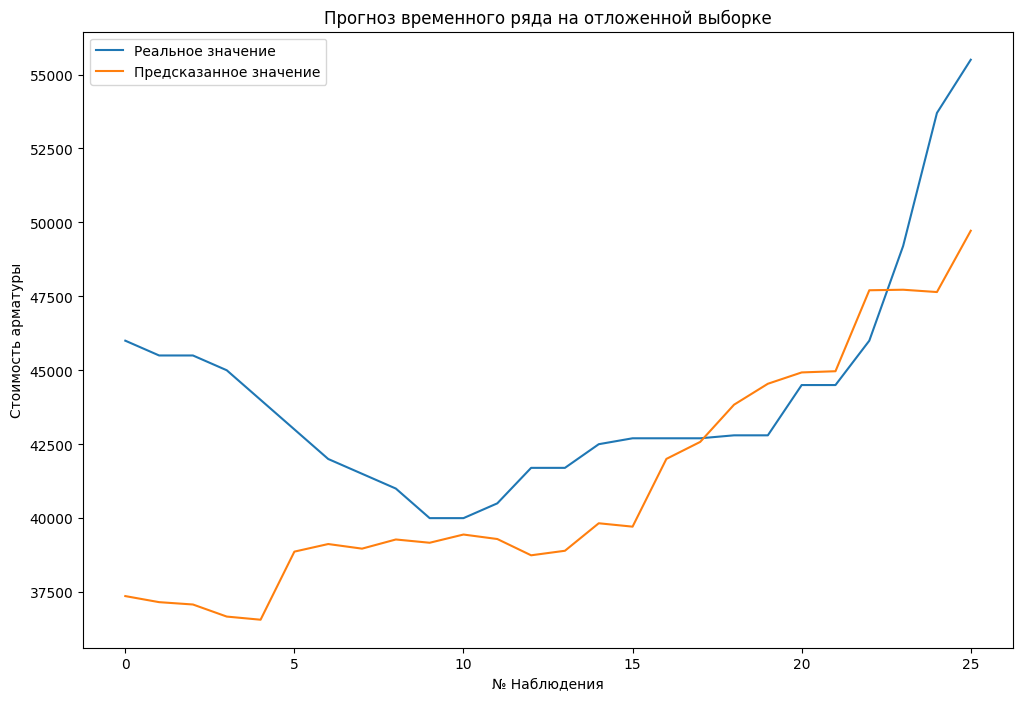

In [63]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=100)


plt.plot(result['real'], label='Реальное значение');
plt.plot(result['pred'], label='Предсказанное значение');
plt.title('Прогноз временного ряда на отложенной выборке')
plt.xlabel('№ Наблюдения')
plt.ylabel('Стоимость арматуры')
plt.legend();


In [64]:
merged_df_cleaned['year'] = merged_df_cleaned['dt'].dt.year
merged_df_cleaned['month'] = merged_df_cleaned['dt'].dt.month
merged_df_cleaned['day'] = merged_df_cleaned['dt'].dt.day
merged_df_cleaned['dayweek'] = merged_df_cleaned['dt'].dt.dayofweek
merged_df_cleaned['dt'] = merged_df_cleaned['dt'].apply(lambda x: int(x.timestamp()))

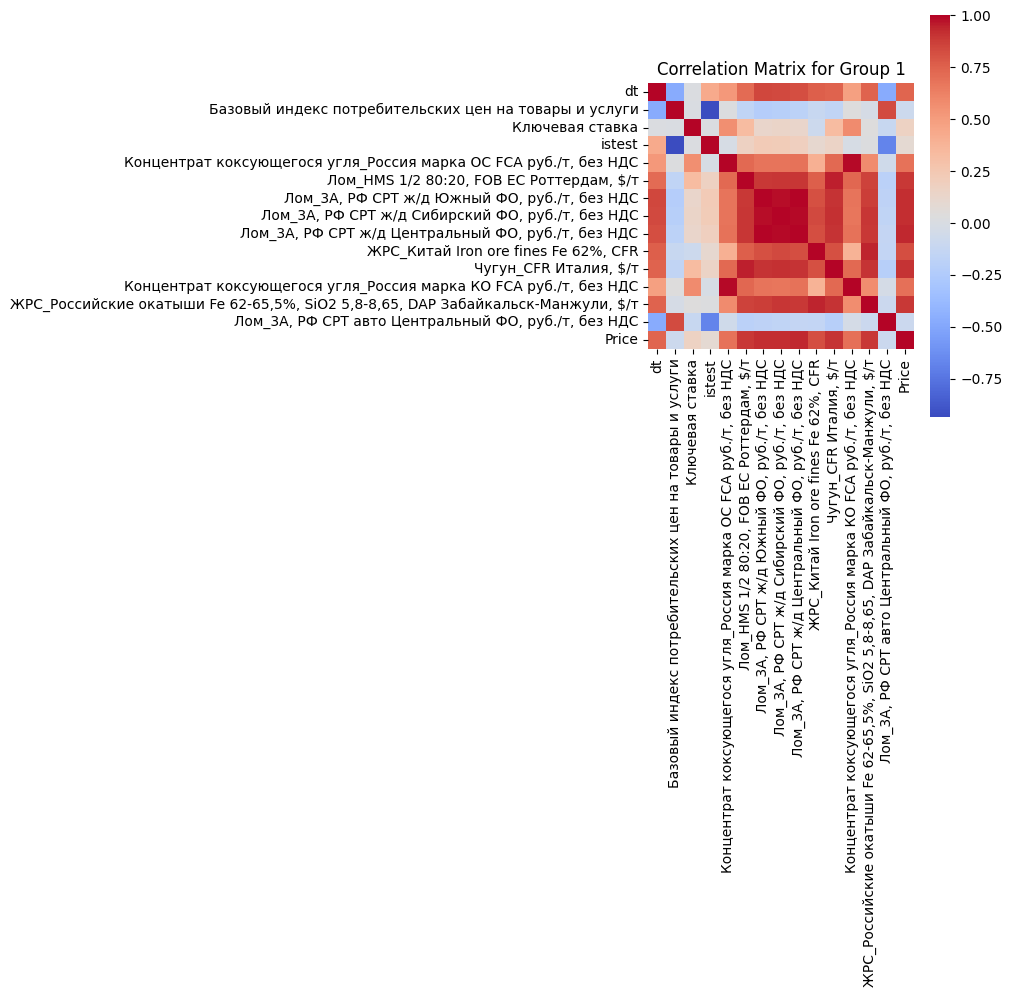

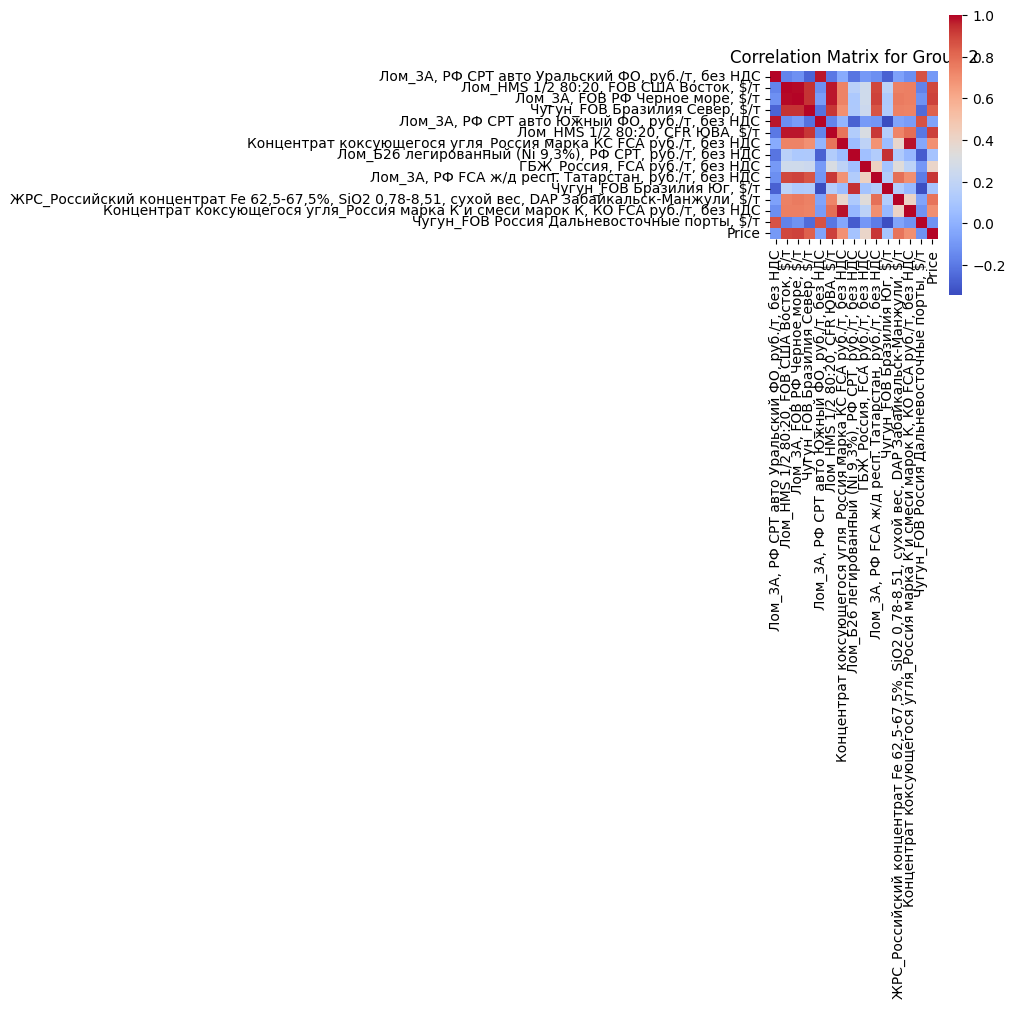

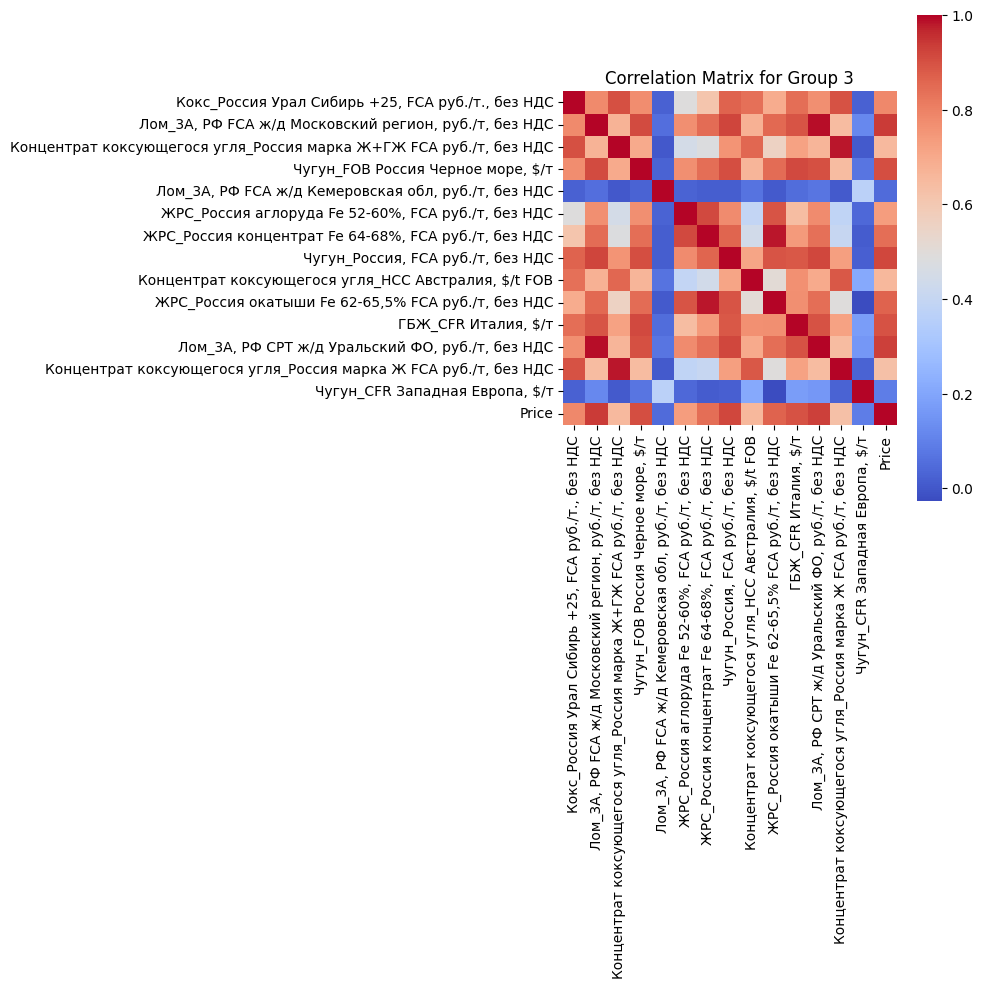

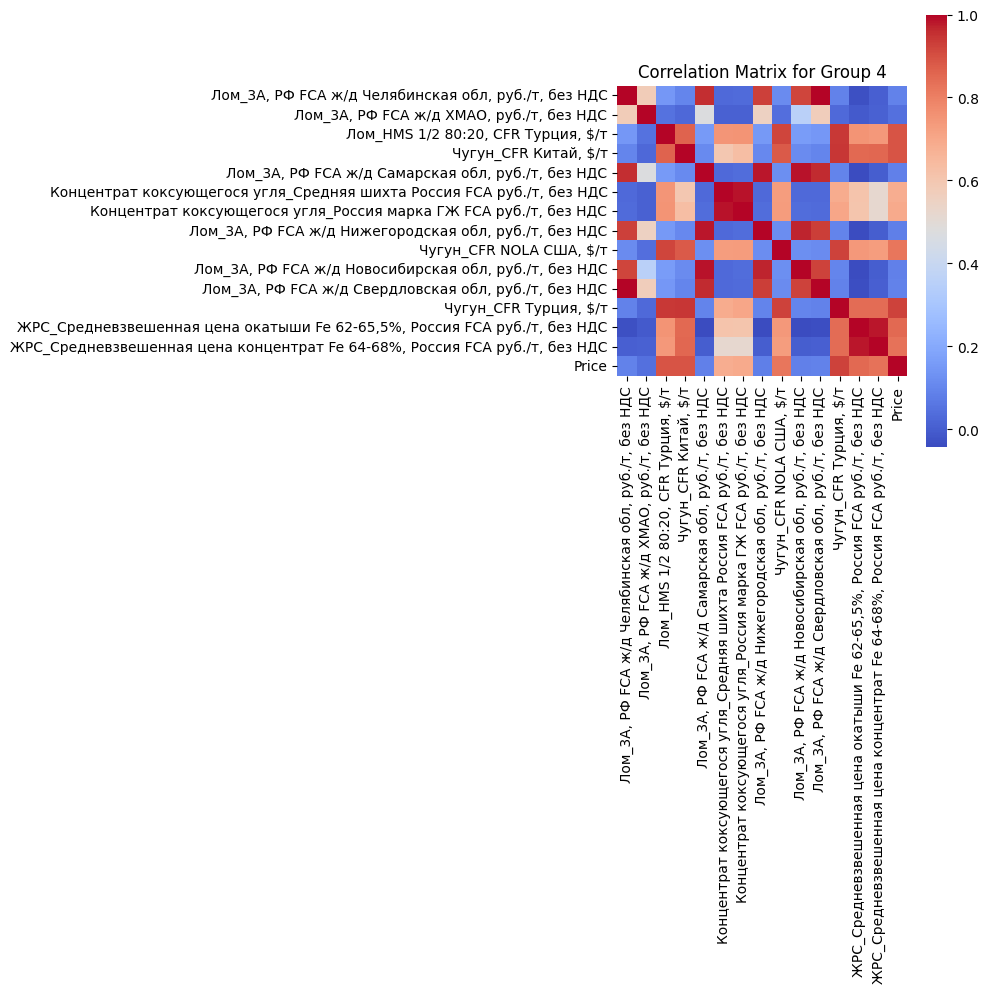

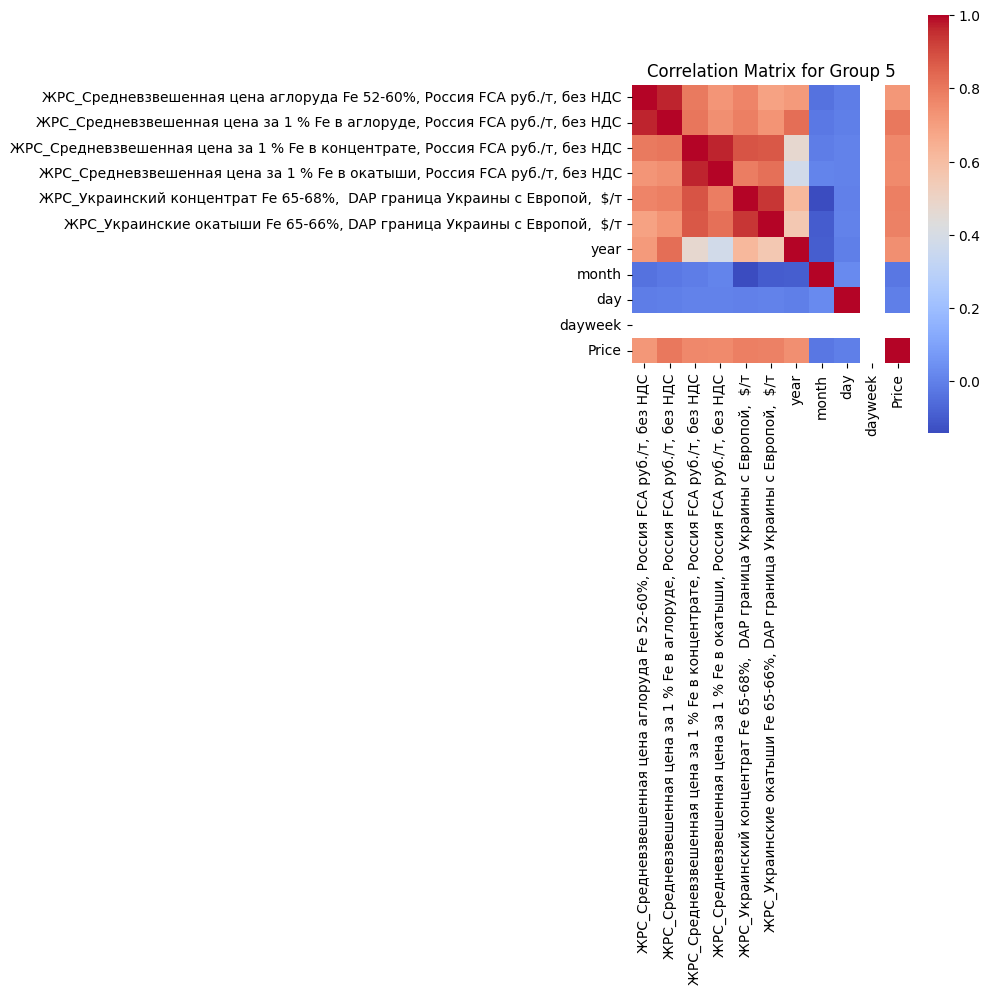

In [65]:
def plot_correlation_matrices(df, target, num_groups=12):
    #  Оставляем только числовые столбцы
    numeric_df = merged_df_cleaned.select_dtypes(include=['number'])

    # Проверяем, что целевая переменная тоже числовая
    if target not in numeric_df.columns:
        raise ValueError(f"Целевая переменная '{target}' должна быть числовой.")

    # Получаем все числовые столбцы, кроме целевой переменной
    feature_columns = [col for col in numeric_df.columns if col != target]

    # Разделяем столбцы на группы (иначе не вместиться)
    group_size = len(feature_columns) // num_groups + 1
    groups = [feature_columns[i:i + group_size] for i in range(0, len(feature_columns), group_size)]

    #  Строим матрицы корреляции для каждой группы
    for i, group in enumerate(groups):
        # Выбираем текущую группу и целевую переменную
        subset = numeric_df[group + [target]]

        # Вычисляем корреляцию
        corr_matrix = subset.corr()

        # Строим heatmap
        plt.figure(figsize=(10, 10))
        sns.heatmap(corr_matrix, annot=False, square=True, cmap="coolwarm", cbar=True)
        plt.title(f'Correlation Matrix for Group {i + 1}')
        plt.tight_layout()
        plt.show()

# Пример вызова
plot_correlation_matrices(merged_df_cleaned, target='Price', num_groups=5)


In [66]:
import yfinance as yf

# Задаем временной диапазон
start_date = "2015-01-05"
end_date = "2023-03-13"

# Загружаем данные по курсу доллара к рублю (USD/RUB)
# Используем тикер "USDRUB=X" для получения курса доллара к рублю
data = yf.download("USDRUB=X", start=start_date, end=end_date, interval="1wk")

# Оставляем только колонку с ценами закрытия (Close)
data = data[['Close']]

# Переименовываем колонку для удобства
data.rename(columns={'Close': 'USD_RUB'}, inplace=True)

# Сбрасываем индекс, чтобы дата стала колонкой
data.reset_index(inplace=True)

# Сохраняем датасет в CSV (опционально)
data.to_csv("usd_rub_weekly_2015_2022.csv", index=False)

# Выводим первые 5 строк датасета
data.tail()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price        Date    USD_RUB
Ticker              USDRUB=X
422    2023-02-06  73.768997
423    2023-02-13  73.964996
424    2023-02-20  75.980003
425    2023-02-27  75.364998
426    2023-03-06  76.165001

In [67]:
# переименовываем столбцы
data = data.rename(columns={'Date': 'dt'})

In [68]:
# Объединяем
# Упрощаем мультииндекс, оставляя только первый уровень
data.columns = data.columns.get_level_values(0)

# Переименовываем колонку 'Date' в 'dt'
data.rename(columns={'Date': 'dt'}, inplace=True)

# Преобразуем колонку 'dt' в формат datetime
data['dt'] = pd.to_datetime(data['dt'])


merged_data = pd.merge(data, raw, on='dt', how='outer')

# Выводим результат
merged_data

dt    USD_RUB  Price  istest
0   2015-01-05  60.250000  32900       0
1   2015-01-12  64.680000  32500       0
2   2015-01-19  64.305000  32000       0
3   2015-01-26  69.252075  30700       0
4   2015-02-02  66.372498  30300       0
..         ...        ...    ...     ...
423 2023-02-13  73.964996  44500       1
424 2023-02-20  75.980003  46000       1
425 2023-02-27  75.364998  49200       1
426 2023-03-06  76.165001  53700       1
427 2023-03-13        NaN  55500       1

[428 rows x 4 columns]

<Axes: >

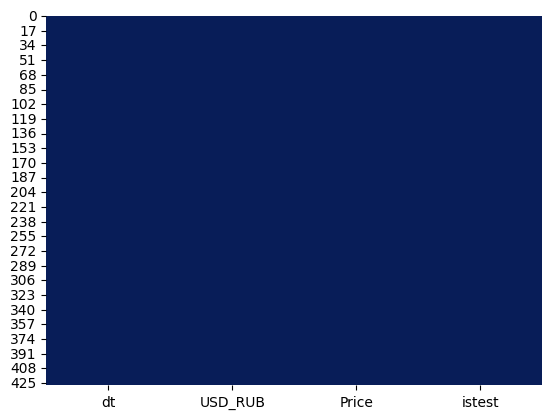

In [69]:
# Заполняем пропуски вперед и назад
merged_data = merged_data.interpolate().ffill().bfill()
merged_data = merged_data.dropna(axis=1)
sns.heatmap(merged_data.isnull(),cmap="YlGnBu_r",cbar=False)


In [70]:
# Разделяем данные на тренировочные и тестовые
split_index = int(0.8 * len(merged_df_cleaned))  # 80% тренировочных данных
train_data = merged_data.iloc[:split_index]
test_data = merged_data.iloc[split_index:]

# Проверяем размеры выборок
print(f"Тренировочные данные: {train_data.shape}")
print(f"Тестовые данные: {test_data.shape}")
# Создадим матрицы со сдвигом, то есть сделаем так, чтобы значение
# цены на следующую неделю являлось "неизвестным для модели"
X = merged_data.drop(columns=['Price']).iloc[:-1, :]
y = merged_data['Price'].values[1:]
# Разделяем данные: 80% - для обучения, 20% - для валидации
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# Проверим размеры выборок
print(f"X_train: {X_train.shape}, X_holdout: {X_holdout.shape}")
print(f"y_train: {y_train.shape}, y_holdout: {y_holdout.shape}")
model0 = CatBoostRegressor(iterations=1000, depth = 10, loss_function='MAE' , learning_rate = 0.03,  eval_metric="MAE",
                           early_stopping_rounds = 50 , random_state=42

                        )
model1 = CatBoostRegressor(iterations=1000, depth = 10, loss_function='MAE' , learning_rate = 0.03,  eval_metric="MAE",
                           early_stopping_rounds = 100 , random_state=52

                        )
model2 = CatBoostRegressor(iterations=1000, depth = 10, loss_function='MAE' , learning_rate = 0.05,  eval_metric="MAE",
                           early_stopping_rounds = 100 , random_state=117

                        )
model0.fit(X_train, y_train, eval_set=(X_holdout , y_holdout)

)
model1.fit(X_train, y_train, eval_set=(X_holdout , y_holdout)

)
model2.fit(X_train, y_train, eval_set=(X_holdout , y_holdout))

ypred = (model0.predict(X_holdout) +
         model1.predict(X_holdout) +
         model2.predict(X_holdout)) / 3

result = pd.DataFrame({'real': y_holdout, 'pred': ypred})
result['error'] = result['real'] - result['pred']
result = result.sort_index()
result.tail(12)


data_for_test = X[X['istest'] == 1]
ypred = (model0.predict(data_for_test) +
         model1.predict(data_for_test) +
         model2.predict(data_for_test)) / 3



result = pd.DataFrame({'real': y[X['istest'] == 1][1:],
              'pred': ypred[:-1]})
result['error'] = result['real'] - result['pred']
result.tail(12)



Тренировочные данные: (338, 4)
Тестовые данные: (90, 4)
X_train: (341, 3), X_holdout: (86, 3)
y_train: (341,), y_holdout: (86,)
0:	learn: 6563.2991229	test: 20642.7790817	best: 20642.7790817 (0)	total: 7.23ms	remaining: 7.23s
1:	learn: 6400.7470884	test: 20327.5056004	best: 20327.5056004 (1)	total: 14.4ms	remaining: 7.19s
2:	learn: 6277.4655668	test: 19618.3872823	best: 19618.3872823 (2)	total: 20.4ms	remaining: 6.77s
3:	learn: 6122.3261957	test: 18949.0308797	best: 18949.0308797 (3)	total: 26.6ms	remaining: 6.61s
4:	learn: 5965.8268628	test: 18690.6322497	best: 18690.6322497 (4)	total: 35.1ms	remaining: 6.99s
5:	learn: 5819.6792174	test: 18402.0664021	best: 18402.0664021 (5)	total: 41.1ms	remaining: 6.8s
6:	learn: 5695.8440162	test: 18172.1376874	best: 18172.1376874 (6)	total: 46.9ms	remaining: 6.66s
7:	learn: 5585.3887812	test: 17861.6231866	best: 17861.6231866 (7)	total: 52.7ms	remaining: 6.54s
8:	learn: 5444.1774792	test: 17594.8935148	best: 17594.8935148 (8)	total: 58.6ms	remainin

real          pred         error
14  42500  44395.217586  -1895.217586
15  42700  62093.128344 -19393.128344
16  42700  63983.758153 -21283.758153
17  42700  65220.838921 -22520.838921
18  42800  61638.897959 -18838.897959
19  42800  62093.128344 -19293.128344
20  44500  64301.777168 -19801.777168
21  44500  63977.383288 -19477.383288
22  46000  63617.705821 -17617.705821
23  49200  62845.586965 -13645.586965
24  53700  59950.636812  -6250.636812
25  55500  60456.811478  -4956.811478

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Предположим, что result['real'] и result['pred'] содержат реальные и предсказанные значения
mae = mean_absolute_error(result['real'], result['pred'])
mse = mean_squared_error(result['real'], result['pred'])
rmse = mse ** 0.5
r2 = r2_score(result['real'], result['pred'])

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 9913.925478731624
MSE: 149923592.42908838
RMSE: 12244.328990560829
R2: -10.064036925344508


In [72]:
# Вычисляем корреляцию всех числовых колонок с 'price'
correlation_with_price = merged_df_cleaned.corr()['Price'].abs().sort_values(ascending=False)

# Выводим корреляции
print("Корреляция с price:")
print(correlation_with_price)

# Выбираем колонки с корреляцией выше порога (например, 0.5)
threshold = 0.5
selected_columns = correlation_with_price[correlation_with_price > threshold].index.tolist()

# Убираем 'price' из списка, так как это целевая переменная
selected_columns = [col for col in selected_columns if col != 'Price']

# Создаем новый датасет из отобранных колонок
new_dataset = merged_df_cleaned[selected_columns]

# Добавляем целевую переменную 'price' в новый датасет
new_dataset['Price'] = merged_df_cleaned['Price']

# Выводим новый датасет
print("\nНовый датасет:")
new_dataset



Корреляция с price:
Price                                                    1.000000
Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС    0.936493
Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС       0.933745
Лом_3А, РФ FCA ж/д респ. Татарстан, руб./т, без НДС      0.929850
Лом_3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС         0.927854
                                                           ...   
Лом_3А, РФ FCA ж/д Кемеровская обл, руб./т, без НДС      0.045123
Лом_3А, РФ FCA ж/д ХМАО, руб./т, без НДС                 0.043539
month                                                    0.026683
day                                                      0.004490
dayweek                                                       NaN
Name: Price, Length: 67, dtype: float64

Новый датасет:


<ipython-input-72-8955cca22002>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataset['Price'] = merged_df_cleaned['Price']


Лом_3А, РФ FCA ж/д Московский регион, руб./т, без НДС  \
5                                               11870.0       
6                                               12088.0       
7                                               12503.0       
8                                               12439.0       
9                                               12020.0       
...                                                 ...       
1739                                            22058.0       
1745                                            22134.0       
1750                                            22039.0       
1756                                            22056.0       
1762                                            23004.0       

      Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС  \
5                                               12728.0    
6                                               12852.0    
7                                               13034.0    
8                                               12910.0    
9                                               12964.0    
...                                                 ...    
1739                                            24100.0    
1745                                            24184.0    
1750                                            24047.0    
1756                                            24055.0    
1762                                            25021.0    

      Лом_3А, РФ FCA ж/д респ. Татарстан, руб./т, без НДС  \
5                                               11573.0     
6                                               11746.0     
7                                               11930.0     
8                                               12100.0     
9                                               11774.0     
...                                                 ...     
1739                                            22626.0     
1745                                            23297.0     
1750                                            23404.0     
1756                                            24078.0     
1762                                            24550.0     

      Лом_3А, РФ CPT ж/д Уральский ФО, руб./т, без НДС  Чугун_CFR Турция, $/т  \
5                                              11598.0                  297.5   
6                                              11794.0                  297.5   
7                                              12047.0                  297.5   
8                                              12253.0                  297.5   
9                                              12183.0                  297.5   
...                                                ...                    ...   
1739                                           24807.0                  457.5   
1745                                           25635.0                  465.0   
1750                                           26010.0                  455.0   
1756                                           26555.0                  467.5   
1762                                           27052.0                  475.0   

      Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС  \
5                                          12344.0   
6                                          12271.0   
7                                          12645.0   
8                                          12696.0   
9                                          12916.0   
...                                            ...   
1739                                       25741.0   
1745                                       25837.0   
1750                                       25814.0   
1756                                       25821.0   
1762                                       26750.0   

      Чугун_Россия, FCA руб./т, без НДС  \
5                               21250.0   
6                               21250.0   
7                               21250.0   
8

In [73]:
# Создаем словарь для замены названий
column_mapping = {col: str(i + 1) for i, col in enumerate(merged_df_cleaned.columns)}

# Переименовываем колонки
merged_df_cleaned.rename(columns=column_mapping, inplace=True)

# Выводим список "ключ-значение"
print("Список замен:")
for old_name, new_name in column_mapping.items():
    print(f"{old_name} -> {new_name}")

# Выводим обновленный DataFrame
print("\nОбновленный DataFrame:")
merged_df_cleaned

Список замен:
dt -> 1
Базовый индекс потребительских цен на товары и услуги -> 2
Ключевая ставка -> 3
Price -> 4
istest -> 5
Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС -> 6
Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т -> 7
Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС -> 8
Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС -> 9
Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС -> 10
ЖРС_Китай Iron ore fines Fe 62%, CFR -> 11
Чугун_CFR Италия, $/т -> 12
Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС -> 13
ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т -> 14
Лом_3А, РФ CPT авто Центральный ФО, руб./т, без НДС -> 15
Лом_3А, РФ CPT авто Уральский ФО, руб./т, без НДС -> 16
Лом_HMS 1/2 80:20, FOB США Восток, $/т -> 17
Лом_3А, FOB РФ Черное море, $/т -> 18
Чугун_FOB Бразилия Север, $/т -> 19
Лом_3А, РФ CPT авто Южный ФО, руб./т, без НДС -> 20
Лом_HMS 1/2 80:20, CFR ЮВА, $/т -> 21
Концентрат коксующегося угля_Россия марка КС FC

1       2     3        4    5        6      7        8  \
5     1423440000  100.82  7.75  30300.0  0.0   3850.0  228.0  12344.0   
6     1424044800  100.82  7.75  30100.0  0.0   3850.0  206.0  12271.0   
7     1424649600  100.82  7.75  29400.0  0.0   3850.0  207.0  12645.0   
8     1425254400  100.82  7.75  29200.0  0.0   3850.0  214.0  12696.0   
9     1425859200  100.82  7.75  29000.0  0.0   4400.0  232.0  12916.0   
...          ...     ...   ...      ...  ...      ...    ...      ...   
1739  1676246400  100.03  7.50  44500.0  1.0   9500.0  399.0  25741.0   
1745  1676851200  100.03  7.50  46000.0  1.0   9500.0  390.0  25837.0   
1750  1677456000  100.03  7.50  49200.0  1.0   9500.0  411.0  25814.0   
1756  1678060800  100.03  7.50  53700.0  1.0  10000.0  422.0  25821.0   
1762  1678665600  100.03  7.50  55500.0  1.0  10000.0  426.0  26750.0   

            9       10  ...      58    59    60     61     62     63    64  \
5     10009.0  12728.0  ...  1261.0  23.0  64.0  101.0   77.0  125.5  2015   
6     10432.0  12852.0  ...  1261.0  23.0  64.0  101.0   77.0  125.5  2015   
7     11981.0  13034.0  ...  1261.0  23.0  64.0  101.0   77.0  125.5  2015   
8     11912.0  12910.0  ...  1261.0  23.0  64.0  101.0   77.0  125.5  2015   
9     12061.0  12964.0  ...  1261.0  23.0  64.0  101.0   77.0  125.5  2015   
...       ...      ...  ...     ...   ...   ...    ...    ...    ...   ...   
1739  23774.0  24100.0  ...  2577.0  50.0  66.0   78.0  116.0  154.0  2023   
1745  24060.0  24184.0  ...  2577.0  50.0  66.0   78.0  116.0  154.0  2023   
1750  24275.0  24047.0  ...  2921.0  56.0  74.0   85.0  122.0  159.0  2023   
1756  25347.0  24055.0  ...  2921.0  56.0  74.0   85.0  122.0  159.0  2023   
1762  25313.0  25021.0  ...  2921.0  56.0  74.0   85.0  122.0  159.0  2023   

      65  66  67  
5      2   9   0  
6      2  16   0  
7      2  23   0  
8      3   2   0  
9      3   9   0  
...   ..  ..  ..  
1739   2  13   0  
1745   2  20   0  
1750   2  27   0  
1756   3   6   0  
1762   3  13   0  

[423 rows x 67 columns]

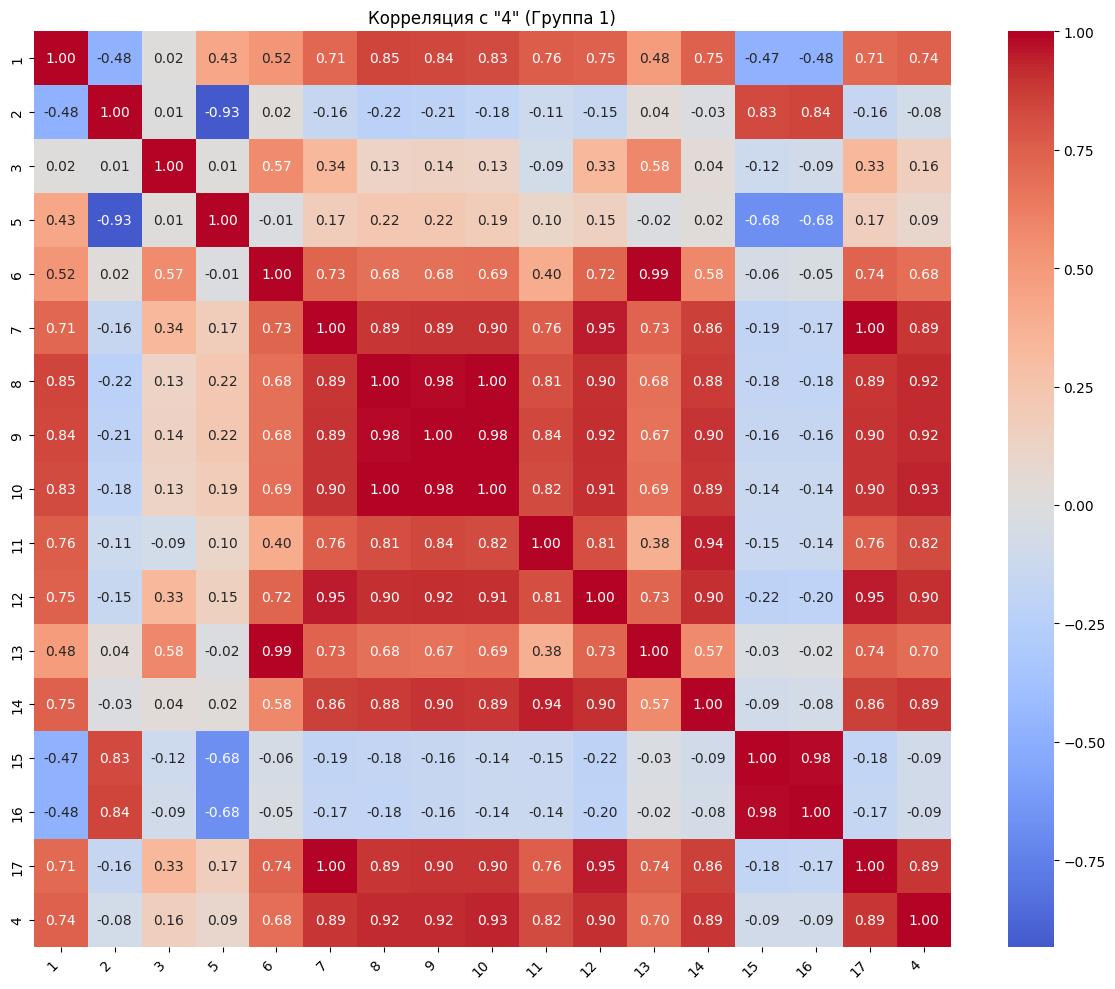

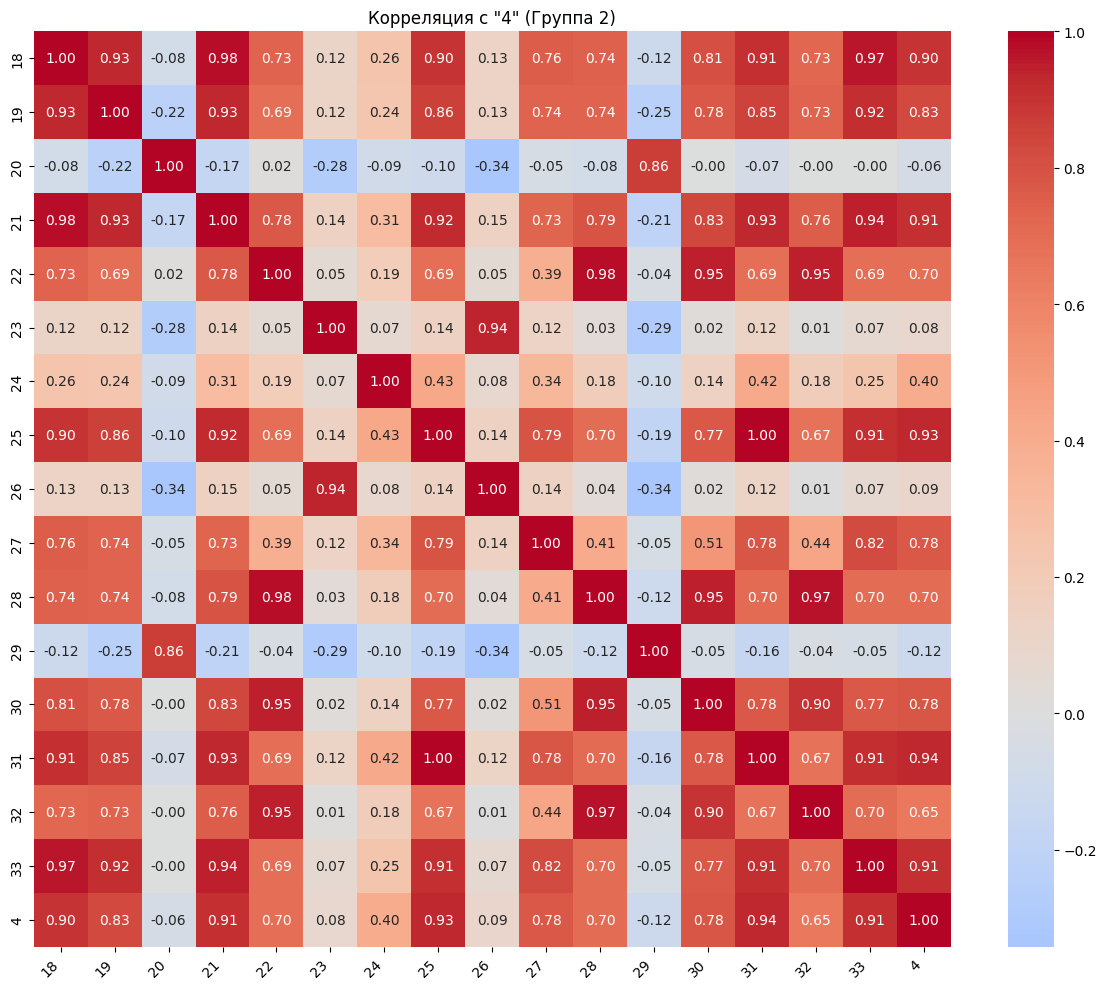

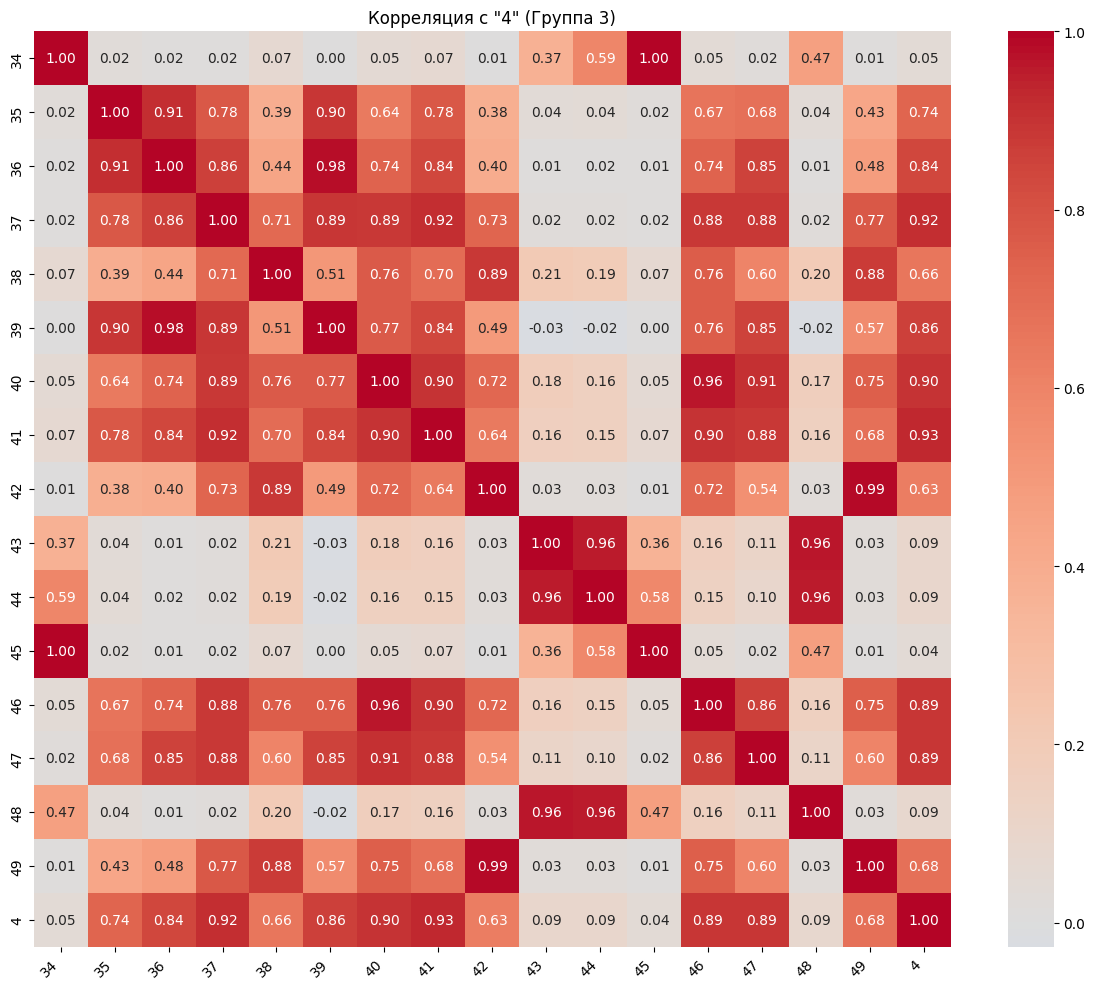

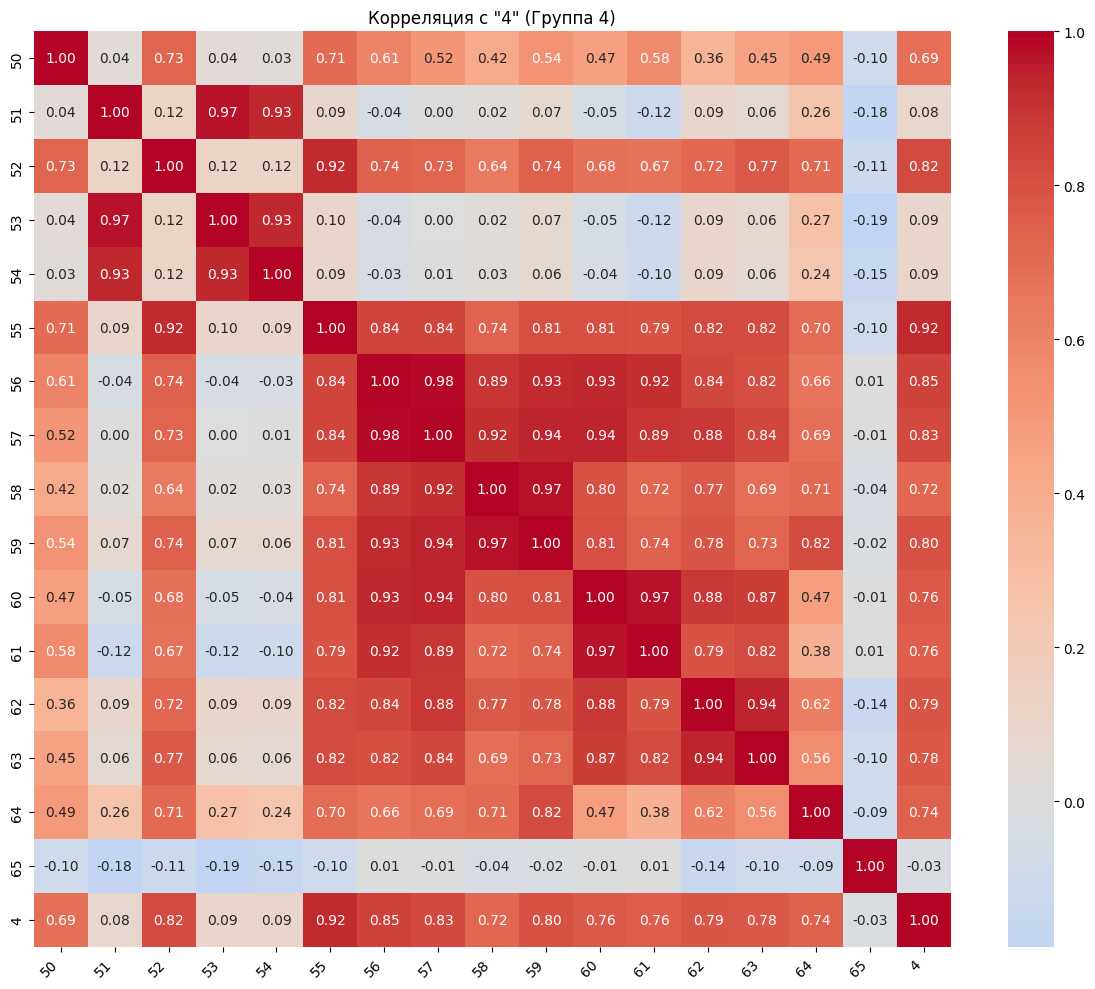

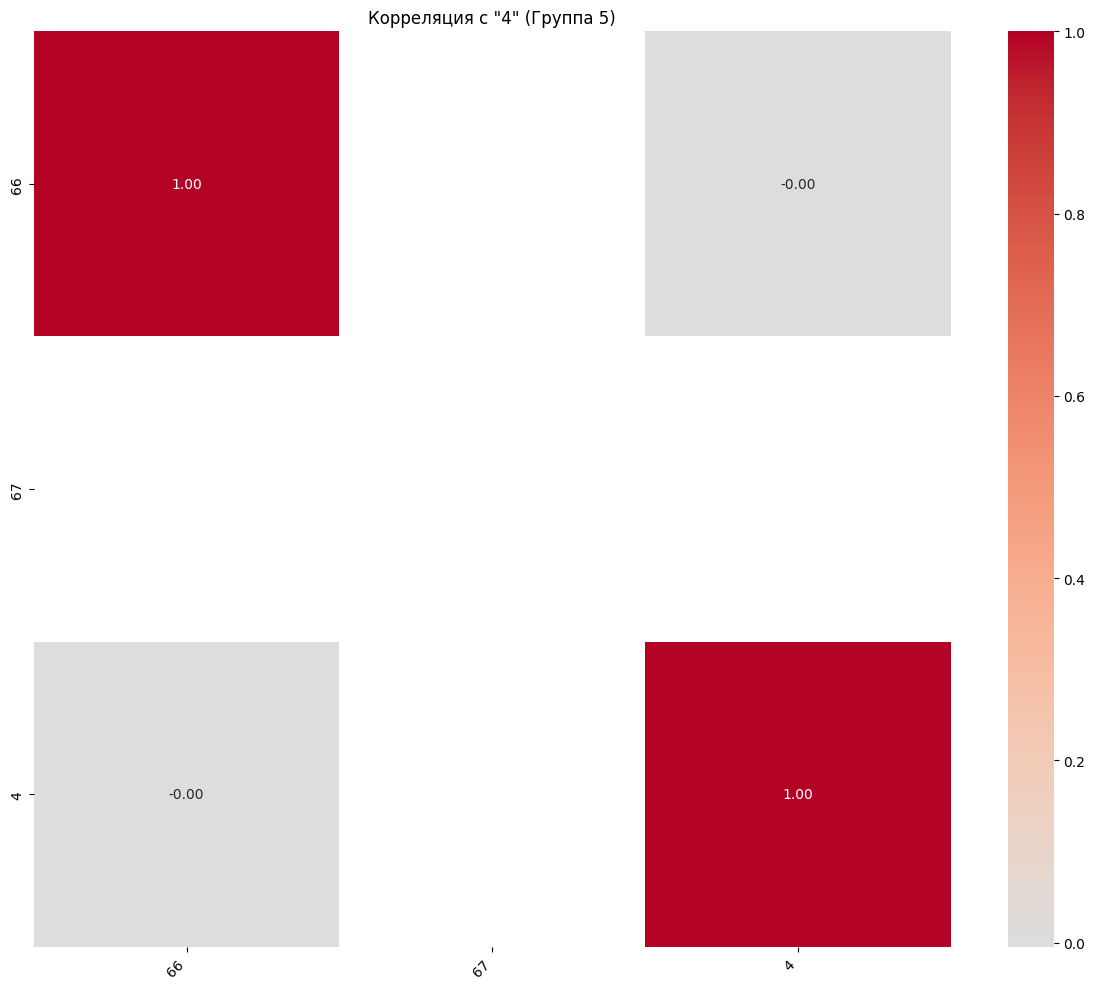

In [74]:
def plot_correlation_matrices_custom_names(df, target='Price', num_groups=2):
    # Проверяем, что целевая переменная есть в DataFrame
    if target not in df.columns:
        raise ValueError(f"Столбец '{target}' отсутствует в DataFrame.")

    # Проверяем, что она числовая
    if not pd.api.types.is_numeric_dtype(df[target]):
        try:
            df[target] = pd.to_numeric(df[target], errors='raise')
        except ValueError:
            raise ValueError(f"Столбец '{target}' не является числовым и не может быть преобразован.")

    # Выбираем ВСЕ числовые столбцы, кроме целевого
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target in numeric_cols:
        numeric_cols.remove(target)

    if not numeric_cols:
        raise ValueError("Нет числовых столбцов для анализа (кроме целевого).")

    # Разбиваем на группы
    group_size = len(numeric_cols) // num_groups
    groups = [numeric_cols[i:i + group_size] for i in range(0, len(numeric_cols), group_size)]

    # Строим матрицы корреляции
    for i, group in enumerate(groups, 1):
        plt.figure(figsize=(12, 10))  # Увеличиваем размер для длинных названий
        corr_matrix = df[group + [target]].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
        plt.title(f'Корреляция с "{target}" (Группа {i})')
        plt.xticks(rotation=45, ha='right')  # Поворачиваем подписи для удобства
        plt.tight_layout()  # Автоматическая подгонка layout
        plt.show()

# Пример вызова с исходными названиями
plot_correlation_matrices_custom_names(merged_df_cleaned, target='4', num_groups=4)

Эксперименты с добавлением внешних данных (макроэкономических показателей, товарных рынков) привели к снижению точности модели из-за усиления шума и мультиколлинеарности. В результате было принято решение вернуться к исходному набору признаков, который демонстрирует более стабильные и интерпретируемые результаты.

В ходе исследования мы тестировали различные подходы, включая отбор ключевых признаков и добавление внешних данных, но все эксперименты приводили к ухудшению точности модели. В итоговый отчет вошла только базовая версия, показавшая наилучшие результаты по стабильности и точности прогнозов и пару эксперементов с доп данными.